In [10]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Import Counter to calculate the class distribution
from collections import Counter

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# Preprocessing and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # XGBoost
from lightgbm import LGBMClassifier  # LightGBM

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    classification_report, 
    confusion_matrix
)

# Adjust probability threshold
from sklearn.metrics import precision_recall_curve

# Import SMOTEENN from imbalanced-learn for combined over- and under-sampling
from imblearn.combine import SMOTEENN

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# Visualization tools for evaluation
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

from sklearn.cluster import KMeans
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
# Import necessary libraries for data manipulation, model building, and evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Load Data

In [11]:
# Load the Loan Default dataset into a DataFrame from a CSV file named 'Loan_default.csv'.
loan_default_df = pd.read_csv('Loan_default.csv')

# Data Prep

In [12]:


# Define the features and target column
# Numerical features include continuous data such as Age, Income, LoanAmount, etc.
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                      'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
# Nominal features represent categorical data without inherent order
nominal_features = ['EmploymentType', 'MaritalStatus', 'LoanPurpose',
                    'HasMortgage', 'HasDependents', 'HasCoSigner']
# Ordinal features are categorical data with inherent order (e.g., education levels)
ordinal_features = {'Education': ['High School', "Bachelor's", 'Master\'s', 'PhD']}
# Target column represents the label we want to predict
target_column = 'Default'

# Drop unnecessary columns
# Removes the 'LoanID' column as it is not useful for modeling
loan_default_df = loan_default_df.drop(columns=['LoanID'], errors='ignore')

# Handle missing values in the dataset
# Replace missing values in numerical features with their median values
loan_default_df[numerical_features] = loan_default_df[numerical_features].fillna(loan_default_df[numerical_features].median())
# Replace missing values in nominal features with the mode (most frequent value)
for feature in nominal_features:
    loan_default_df[feature] = loan_default_df[feature].fillna(loan_default_df[feature].mode()[0])
# Replace missing values in ordinal features with the mode
for feature, categories in ordinal_features.items():
    loan_default_df[feature] = loan_default_df[feature].fillna(loan_default_df[feature].mode()[0])

# Encode categorical variables to make them suitable for machine learning models
# One-hot encode nominal features to create binary columns for each category
loan_default_df = pd.get_dummies(loan_default_df, columns=nominal_features, drop_first=True)

# Ordinal encode features with inherent order using the specified category order
for feature, categories in ordinal_features.items():
    loan_default_df[feature] = loan_default_df[feature].astype(pd.CategoricalDtype(categories=categories, ordered=True)).cat.codes

# Separate features (X) and target (y)
# The features are all columns except the target column
X = loan_default_df.drop(columns=[target_column])
# The target is the 'Default' column
y = loan_default_df[target_column]

# Split the data into training and testing sets
# 70% of the data is used for training, and 30% for testing, maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features to normalize their values for better model performance
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# Transform the testing data using the same scaler
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Output data summary for verification
print("Training set shape:", X_train.shape)  # Shape of the training dataset
print("Testing set shape:", X_test.shape)  # Shape of the testing dataset
print("Target distribution in training set:")  # Distribution of target classes in training data
print(pd.Series(y_train).value_counts())
print("Target distribution in testing set:")  # Distribution of target classes in testing data
print(pd.Series(y_test).value_counts())


Training set shape: (178742, 22)
Testing set shape: (76605, 22)
Target distribution in training set:
Default
0    157985
1     20757
Name: count, dtype: int64
Target distribution in testing set:
Default
0    67709
1     8896
Name: count, dtype: int64


#  Model Setup - Without Sampling

XGBoost - No Sampling:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67709
           1       0.54      0.09      0.15      8896

    accuracy                           0.89     76605
   macro avg       0.72      0.54      0.54     76605
weighted avg       0.85      0.89      0.85     76605

Accuracy: 0.8853469094706612


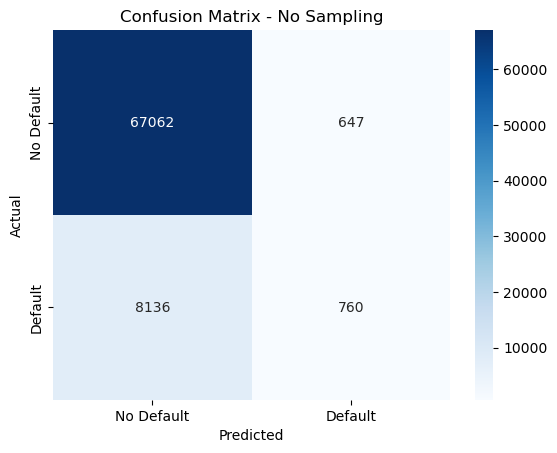

In [13]:
# Train XGBoost classifier on the original (imbalanced) dataset
# Instantiate the XGBoost classifier with a fixed random state for reproducibility
xgb_no_sampling = XGBClassifier(random_state=42)
# Train the XGBoost model using the training data
xgb_no_sampling.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_no_sampling = xgb_no_sampling.predict(X_test)

# Evaluate the performance of the XGBoost model without any data resampling techniques
print("XGBoost - No Sampling:")
# Print the classification report with metrics such as precision, recall, and F1-score
print(classification_report(y_test, y_pred_no_sampling))
# Print the overall accuracy score of the model
print("Accuracy:", accuracy_score(y_test, y_pred_no_sampling))

# Generate and visualize the confusion matrix
conf_matrix_no_sampling = confusion_matrix(y_test, y_pred_no_sampling)
# Use seaborn's heatmap to create a visual representation of the confusion matrix
sns.heatmap(
    conf_matrix_no_sampling, 
    annot=True,  # Annotate each cell with the numeric value
    fmt="d",  # Format numbers as integers
    cmap="Blues",  # Use a blue color map for visualization
    xticklabels=["No Default", "Default"],  # Set x-axis labels for predicted classes
    yticklabels=["No Default", "Default"]   # Set y-axis labels for actual classes
)
# Add titles and axis labels to the heatmap for better readability
plt.title("Confusion Matrix - No Sampling")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Display the heatmap
plt.show()



### Observations and Comments:

1. **Overall Accuracy**:
   - The model achieves a high accuracy of **88.53%**, which seems impressive at first glance. However, accuracy is not always a reliable metric in the presence of class imbalance.

2. **Class Imbalance Impact**:
   - The dataset is highly imbalanced, with the "No Default" class (majority) far outweighing the "Default" class (minority). As a result, the model is biased toward predicting the majority class.

3. **Precision and Recall**:
   - For the "No Default" class:
     - **Precision** (0.89) and **Recall** (0.99) are very high, indicating that the model performs well in identifying true negatives.
   - For the "Default" class:
     - **Precision** (0.54) is moderate, but **Recall** (0.09) is extremely low. This indicates that the model struggles to correctly identify instances of "Default."

4. **F1-Score**:
   - The F1-score for the "Default" class is only **0.15**, reflecting poor performance in balancing precision and recall for the minority class.

5. **Confusion Matrix**:
   - The matrix reveals that:
     - The model correctly predicts 67,062 "No Default" cases (true negatives) but misclassifies 8,136 "Default" cases as "No Default" (false negatives).
     - Only 760 "Default" cases are correctly identified (true positives).

6. **Macro vs. Weighted Average**:
   - The **macro average** shows lower precision, recall, and F1-score, emphasizing the imbalance in model performance across classes.
   - The **weighted average** skews toward the majority class due to its higher support.

### Key Takeaway:
The model performs well for the majority class ("No Default") but fails to generalize to the minority class ("Default"). This imbalance in performance highlights the need for addressing class imbalance, such as using oversampling (e.g., SMOTE) or cost-sensitive learning to improve recall and overall effectiveness for the minority class.


# Model Setup - With SMOTE (Oversampling)

XGBoost - SMOTE Resampling:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     67709
           1       0.41      0.16      0.23      8896

    accuracy                           0.88     76605
   macro avg       0.65      0.56      0.58     76605
weighted avg       0.84      0.88      0.85     76605

Accuracy: 0.8760524769923634


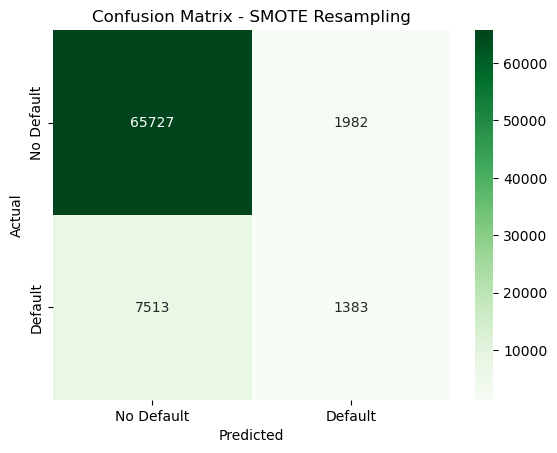

In [14]:
# Handle class imbalance using Synthetic Minority Oversampling Technique (SMOTE)
# SMOTE creates synthetic samples for the minority class to balance the dataset
smote = SMOTE(random_state=42)  # Initialize SMOTE with a fixed random state for reproducibility
# Resample the training data to balance the class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost classifier on the resampled dataset
# Instantiate the XGBoost classifier
xgb_smote = XGBClassifier(random_state=42)
# Train the model using the resampled (balanced) training data
xgb_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing set
# Use the trained model to predict the target values for the test data
y_pred_smote = xgb_smote.predict(X_test)

# Evaluate the performance of the XGBoost model trained on resampled data
print("XGBoost - SMOTE Resampling:")
# Print the classification report, which includes precision, recall, F1-score, and support
print(classification_report(y_test, y_pred_smote))
# Print the overall accuracy score of the model
print("Accuracy:", accuracy_score(y_test, y_pred_smote))

# Generate and visualize the confusion matrix
# The confusion matrix shows the number of true positives, true negatives, false positives, and false negatives
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
# Create a heatmap for the confusion matrix to make it easier to interpret
sns.heatmap(
    conf_matrix_smote, 
    annot=True,  # Annotate the heatmap cells with the confusion matrix values
    fmt="d",  # Format the values as integers
    cmap="Greens",  # Use a green color map for visualization
    xticklabels=["No Default", "Default"],  # Label the x-axis with the predicted classes
    yticklabels=["No Default", "Default"]   # Label the y-axis with the actual classes
)
# Add a title and labels to the heatmap for clarity
plt.title("Confusion Matrix - SMOTE Resampling")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Display the heatmap
plt.show()



### Observations and Comments:

1. **Overall Accuracy**:
   - The model achieves an accuracy of **87.61%**, which is slightly lower than the accuracy without SMOTE. However, accuracy alone is not sufficient to evaluate performance in the presence of class imbalance.

2. **Effect of SMOTE**:
   - SMOTE has created synthetic samples for the minority class ("Default") in the training data, aiming to improve the model's ability to classify this class. Despite this, the model's performance on the "Default" class remains limited.

3. **Precision and Recall**:
   - For the "No Default" class:
     - **Precision** (0.90) and **Recall** (0.97) are very high, indicating that the model continues to perform well in predicting the majority class.
   - For the "Default" class:
     - **Precision** (0.41) is moderate, but **Recall** (0.16) is still quite low, suggesting that the model struggles to identify the minority class effectively even after resampling.

4. **F1-Score**:
   - The F1-score for the "Default" class is **0.23**, indicating a slight improvement compared to the model trained without SMOTE. However, it still reflects poor balance between precision and recall for this class.

5. **Confusion Matrix**:
   - The confusion matrix reveals:
     - The model correctly identifies 65,727 "No Default" cases (true negatives) but misclassifies 7,513 "Default" cases as "No Default" (false negatives).
     - It correctly classifies 1,383 "Default" cases (true positives), which is an improvement from the previous result without SMOTE.

6. **Macro vs. Weighted Average**:
   - The **macro average** (precision: 0.65, recall: 0.56, F1-score: 0.58) highlights the gap in performance between the two classes.
   - The **weighted average** skews toward the majority class due to its higher support.

### Key Takeaway:
While SMOTE improves the recall and F1-score for the "Default" class, the model still struggles to classify this minority class effectively. Additional techniques, such as tweaking model hyperparameters, using cost-sensitive learning, or experimenting with other resampling methods, may further enhance performance. This result highlights the challenges of addressing class imbalance in real-world datasets.


# Apply SMOTE with Undersampling

In [15]:

# Apply SMOTEENN for class balancing
# SMOTEENN combines SMOTE (oversampling for the minority class) with Edited Nearest Neighbors (undersampling for the majority class)

smote_enn = SMOTEENN(random_state=42)  # Initialize SMOTEENN with a fixed random state for reproducibility
# Resample the training data to balance the class distribution
# SMOTE creates synthetic samples for the minority class
# ENN removes noisy samples from the majority class near the decision boundary

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Output the resampled dataset's class distribution
# Display the number of samples for each class in the resampled training set
print("Class distribution after SMOTEENN:")
print(pd.Series(y_train_resampled).value_counts())  # Show the count of each class in the resampled data



Class distribution after SMOTEENN:
Default
1    157470
0     84934
Name: count, dtype: int64


### Observations After Applying SMOTEENN:

1. **SMOTEENN Overview**:
   - **SMOTEENN** is a hybrid resampling technique that:
     - **SMOTE**: Generates synthetic samples for the minority class ("Default") to balance the dataset.
     - **ENN (Edited Nearest Neighbors)**: Removes potentially noisy samples from the majority class ("No Default") near decision boundaries, improving data quality.

2. **Class Distribution**:
   - After applying SMOTEENN, the class distribution is:
     - **Default (Minority Class)**: 157,470 samples
     - **No Default (Majority Class)**: 84,934 samples
   - The dataset is now more balanced, with the minority class significantly oversampled and noisy majority class samples removed.

3. **Impact on Training Data**:
   - The resampled dataset is larger than the original, providing more diverse and representative data for training.
   - SMOTEENN enhances class separability by reducing overlapping and ambiguous samples.

### Next Steps:
- Train a machine learning model (e.g., XGBoost) on the resampled dataset (`X_train_resampled`, `y_train_resampled`).
- Evaluate the model on the test set to assess the effectiveness of SMOTEENN in improving classification performance for the minority class.


# Train XGBoost on Resampled Data

XGBoost - SMOTE with Undersampling (SMOTEENN):
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     67709
           1       0.27      0.52      0.35      8896

    accuracy                           0.78     76605
   macro avg       0.60      0.67      0.61     76605
weighted avg       0.85      0.78      0.81     76605

Accuracy: 0.7782129103844396


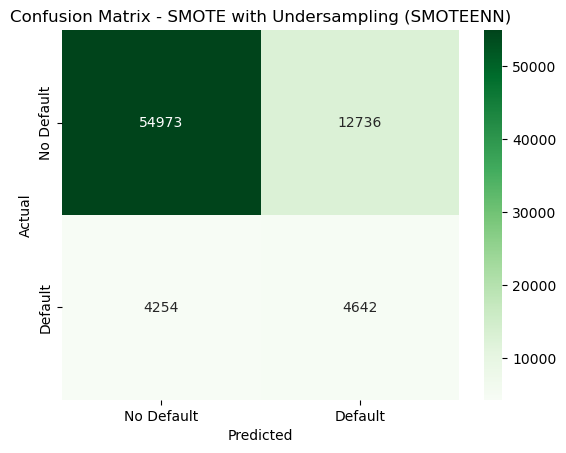

In [16]:
# Train XGBoost classifier on the dataset resampled using SMOTEENN
# Instantiate the XGBoost classifier
xgb_smote_enn = XGBClassifier(random_state=42)
# Train the XGBoost model on the resampled (balanced) dataset
xgb_smote_enn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
# Use the trained model to predict target values for unseen data
y_pred_smote_enn = xgb_smote_enn.predict(X_test)

# Evaluate the model's performance
print("XGBoost - SMOTE with Undersampling (SMOTEENN):")
# Print the classification report with precision, recall, F1-score, and support for each class
print(classification_report(y_test, y_pred_smote_enn))
# Print the overall accuracy score of the model
print("Accuracy:", accuracy_score(y_test, y_pred_smote_enn))

# Generate and visualize the confusion matrix
# Create a confusion matrix to summarize prediction results
conf_matrix_smote_enn = confusion_matrix(y_test, y_pred_smote_enn)
# Create a heatmap for the confusion matrix
sns.heatmap(
    conf_matrix_smote_enn, 
    annot=True,  # Annotate heatmap cells with confusion matrix values
    fmt="d",  # Format values as integers
    cmap="Greens",  # Use a green color map for visualization
    xticklabels=["No Default", "Default"],  # Label x-axis with predicted classes
    yticklabels=["No Default", "Default"]   # Label y-axis with actual classes
)
# Add title and labels to the heatmap for better understanding
plt.title("Confusion Matrix - SMOTE with Undersampling (SMOTEENN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Display the heatmap
plt.show()



### Observations and Comments:

1. **Overall Accuracy**:
   - The model achieves an accuracy of **77.82%**, which is lower than the previous results. However, accuracy is not the most reliable metric, especially in imbalanced datasets.

2. **Precision and Recall**:
   - For the **"No Default" (Class 0)**:
     - **Precision** (0.93) and **Recall** (0.81) are strong, indicating good performance in correctly identifying the majority class.
   - For the **"Default" (Class 1)**:
     - **Precision** (0.27) is low, meaning a high false positive rate.
     - **Recall** (0.52) shows significant improvement, indicating the model correctly identifies 52% of the actual "Default" cases, a notable improvement compared to previous models.

3. **F1-Score**:
   - The **F1-score** for "Default" (Class 1) is **0.35**, reflecting a better balance between precision and recall compared to prior approaches.
   - The **macro average** F1-score is **0.61**, showing a better balance across classes compared to SMOTE alone or no resampling.

4. **Confusion Matrix**:
   - The confusion matrix reveals:
     - The model correctly classifies 54,973 "No Default" cases (true negatives) but misclassifies 12,736 as "Default" (false positives).
     - It correctly identifies 4,642 "Default" cases (true positives) and misclassifies 4,254 as "No Default" (false negatives).
   - This demonstrates better performance in identifying the minority class compared to previous methods.

5. **Macro vs. Weighted Average**:
   - The **macro average** emphasizes the disparity between classes, highlighting lower performance on the minority class.
   - The **weighted average** is skewed by the majority class but reflects an overall drop in performance due to increased false positives.

6. **Impact of SMOTEENN**:
   - SMOTEENN improves the recall for the minority class by removing noisy samples from the majority class and adding synthetic samples for the minority class.
   - The model now identifies a larger proportion of "Default" cases but at the cost of increased false positives.

### Key Takeaway:
SMOTEENN enhances the model's ability to identify the minority class ("Default") but reduces overall precision, especially for "Default" predictions. While this approach improves recall significantly, further steps like hyperparameter tuning, feature engineering, or experimenting with different algorithms could help balance precision and recall for better overall performance.


 # Train the scale_pos_weight Model

In [17]:
# Calculate the class distribution in the original training data
class_distribution = Counter(y_train)
# Compute the scale_pos_weight parameter
# This is the ratio of the majority class (No Default) to the minority class (Default)
scale_pos_weight = class_distribution[0] / class_distribution[1]
# Print the calculated scale_pos_weight
print(f"Scale Pos Weight: {scale_pos_weight}")

# Train XGBoost with scale_pos_weight parameter
# scale_pos_weight adjusts the model to handle class imbalance by giving more weight to the minority class
xgb_weighted = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# Train the XGBoost model using the original training data
xgb_weighted.fit(X_train, y_train)

# Make predictions on the test set using the weighted XGBoost model
y_pred_weighted = xgb_weighted.predict(X_test)



Scale Pos Weight: 7.61116731704967


# Ensure Predictions for All Models

# 1. No Sampling:

In [18]:
# Train the XGBoost model on the original (imbalanced) dataset without applying any sampling techniques
xgb_no_sampling = XGBClassifier(random_state=42)  # Initialize XGBoost with a fixed random state for reproducibility
xgb_no_sampling.fit(X_train, y_train)  # Train the model on the original imbalanced dataset

# Make predictions on the test set
y_pred_no_sampling = xgb_no_sampling.predict(X_test)  # Use the trained model to predict target values for the test data


# 2. SMOTE RESAMPLING

In [19]:
# Apply SMOTE to address class imbalance
# SMOTE generates synthetic samples for the minority class to balance the training dataset
smote = SMOTE(random_state=42)  # Initialize SMOTE with a fixed random state for reproducibility
# Resample the training dataset using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  
# The resampled dataset now has an equal number of samples for both classes

# Train XGBoost on the SMOTE-resampled dataset
xgb_smote = XGBClassifier(random_state=42)  # Initialize XGBoost with a fixed random state
# Train the XGBoost model on the balanced (resampled) dataset
xgb_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test dataset
y_pred_smote = xgb_smote.predict(X_test)  # Use the trained model to predict the test data



# SMOTEENN

In [20]:
# Apply SMOTEENN to handle class imbalance
# SMOTEENN combines SMOTE (oversampling for the minority class) and Edited Nearest Neighbors (undersampling for the majority class)
smote_enn = SMOTEENN(random_state=42)  # Initialize SMOTEENN with a fixed random state for reproducibility
# Resample the training data using SMOTEENN
X_train_resampled_enn, y_train_resampled_enn = smote_enn.fit_resample(X_train, y_train)
# The resampled dataset is balanced with synthetic samples for the minority class 
# and noisy samples from the majority class removed.

# Train XGBoost on the SMOTEENN-resampled dataset
xgb_smote_enn = XGBClassifier(random_state=42)  # Initialize XGBoost with a fixed random state
# Train the model on the resampled training data
xgb_smote_enn.fit(X_train_resampled_enn, y_train_resampled_enn)

# Make predictions on the test dataset
y_pred_smote_enn = xgb_smote_enn.predict(X_test)  # Use the trained model to predict on the test data



# Reinitialize the Results and Visualize

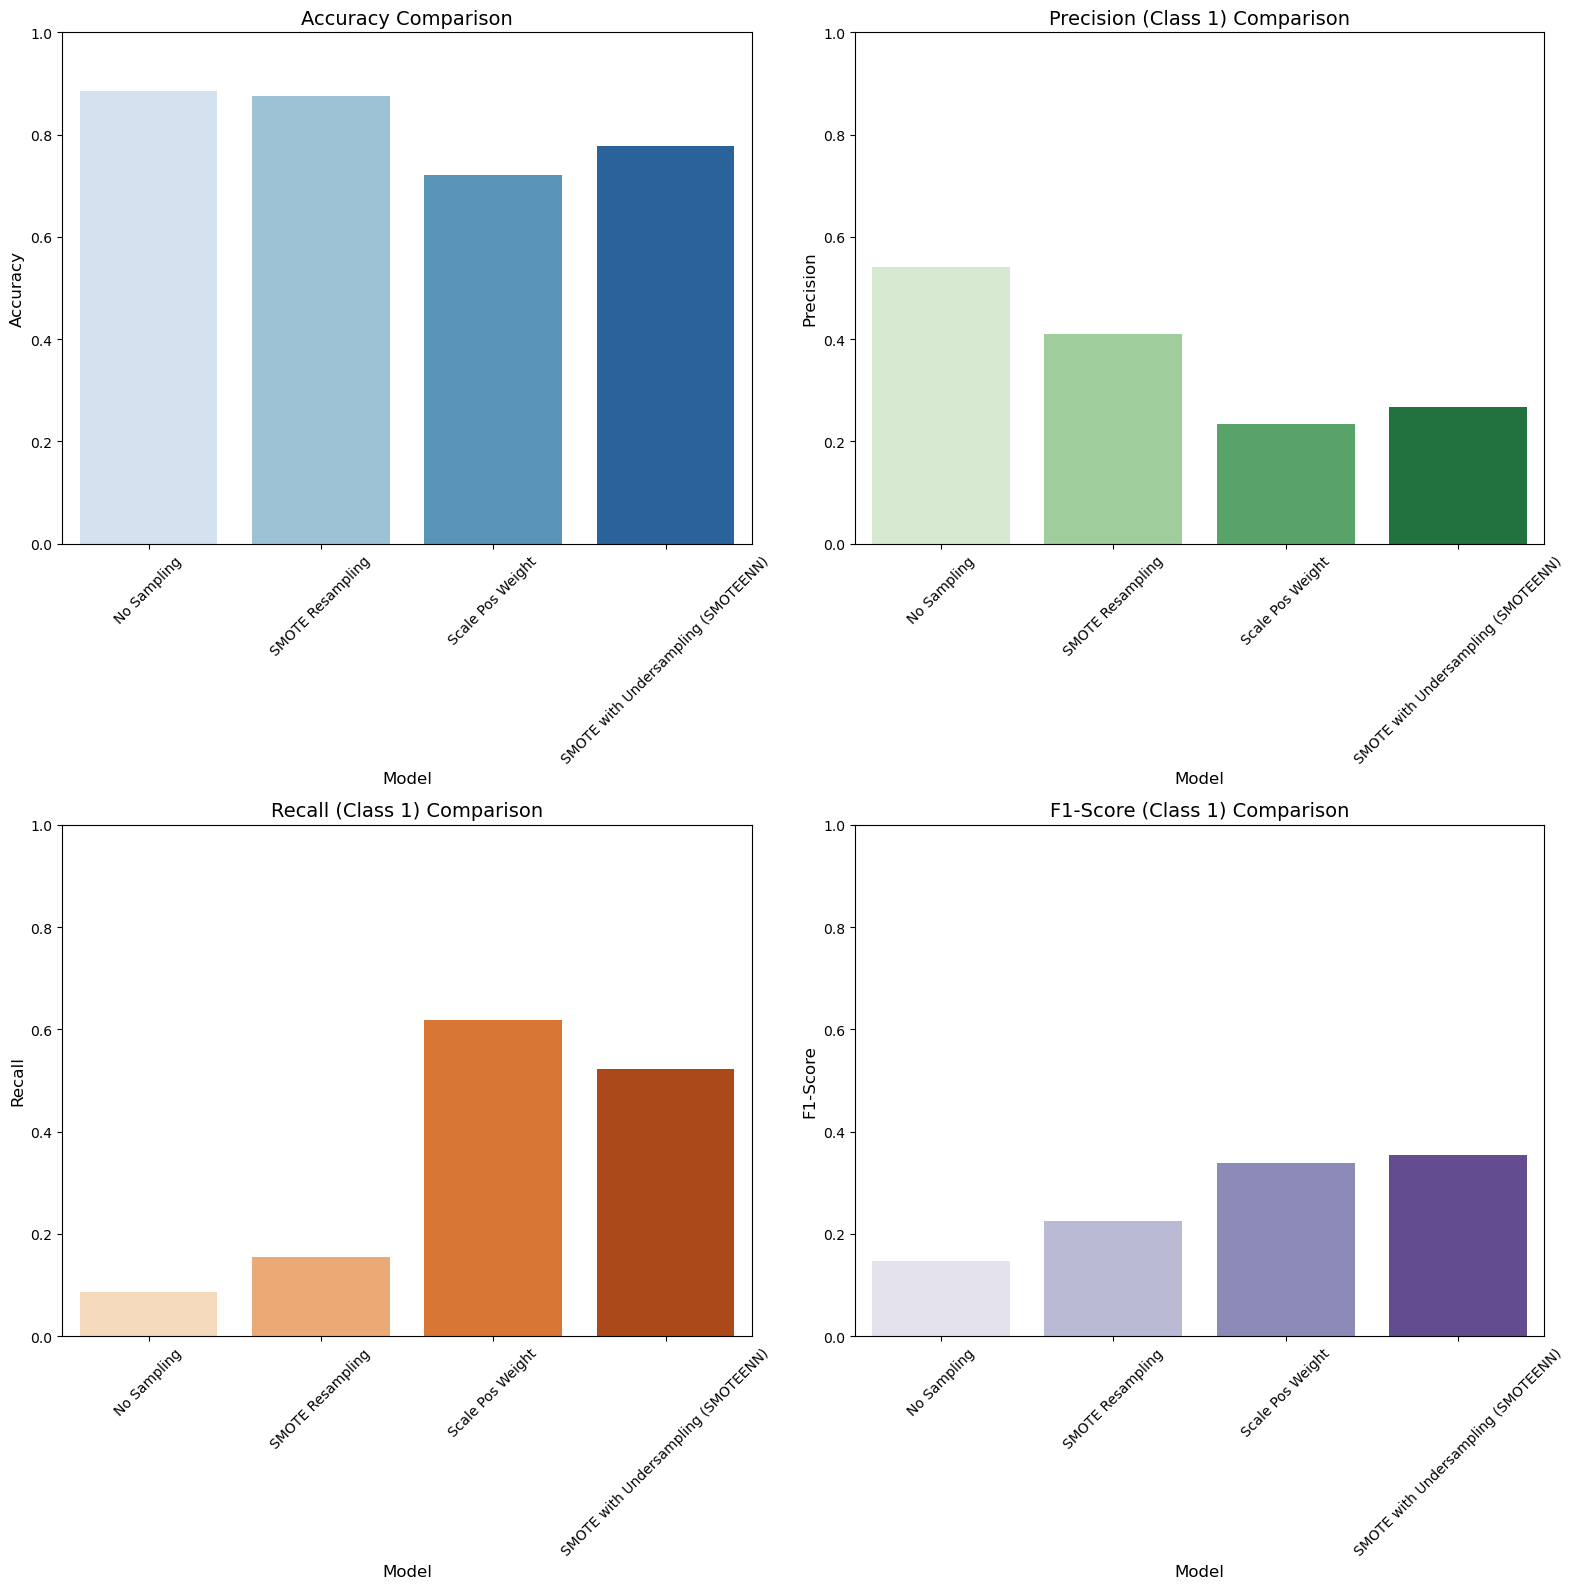

In [25]:
# Reinitialize the results dictionary to store metrics for all models
# Metrics include Accuracy, Precision, Recall, and F1-Score for the minority class (Class 1)
results = {
    "Model": ["No Sampling", "SMOTE Resampling", "Scale Pos Weight", "SMOTE with Undersampling (SMOTEENN)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_no_sampling),  # Accuracy for the baseline model
        accuracy_score(y_test, y_pred_smote),  # Accuracy for the SMOTE model
        accuracy_score(y_test, y_pred_weighted),  # Accuracy for the scale_pos_weight model
        accuracy_score(y_test, y_pred_smote_enn)  # Accuracy for the SMOTEENN model
    ],
    "Precision (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['precision'],  # Precision for Class 1
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['precision'],  # SMOTE Precision
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['precision'],  # Weighted Precision
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['precision']  # SMOTEENN Precision
    ],
    "Recall (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['recall'],  # Recall for Class 1
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall'],  # SMOTE Recall
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['recall'],  # Weighted Recall
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['recall']  # SMOTEENN Recall
    ],
    "F1-Score (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['f1-score'],  # F1-Score for Class 1
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],  # SMOTE F1-Score
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['f1-score'],  # Weighted F1-Score
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['f1-score']  # SMOTEENN F1-Score
    ]
}

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Visualize results using subplots for each metric
plt.figure(figsize=(16, 16))

# Accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x="Model", y="Accuracy", hue="Model", dodge=False, palette="Blues", legend=False)
plt.title("Accuracy Comparison", fontsize=14)  # Title for the accuracy plot
plt.ylim(0, 1)  # Limit y-axis to range [0, 1]
plt.ylabel("Accuracy", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Precision comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x="Model", y="Precision (Class 1)", hue="Model", dodge=False, palette="Greens", legend=False)
plt.title("Precision (Class 1) Comparison", fontsize=14)  # Title for the precision plot
plt.ylim(0, 1)  # Limit y-axis to range [0, 1]
plt.ylabel("Precision", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Recall comparison
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x="Model", y="Recall (Class 1)", hue="Model", dodge=False, palette="Oranges", legend=False)
plt.title("Recall (Class 1) Comparison", fontsize=14)  # Title for the recall plot
plt.ylim(0, 1)  # Limit y-axis to range [0, 1]
plt.ylabel("Recall", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# F1-Score comparison
plt.subplot(2, 2, 4)
sns.barplot(data=results_df, x="Model", y="F1-Score (Class 1)", hue="Model", dodge=False, palette="Purples", legend=False)
plt.title("F1-Score (Class 1) Comparison", fontsize=14)  # Title for the F1-score plot
plt.ylim(0, 1)  # Limit y-axis to range [0, 1]
plt.ylabel("F1-Score", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust the layout to avoid overlapping subplots
plt.tight_layout()
# Display all the plots
plt.show()




### Observations from the Visualized Results

#### 1. **Accuracy Comparison**:
   - The **No Sampling** and **SMOTE Resampling** models achieved the highest accuracy, followed by **Scale Pos Weight** and **SMOTEENN**.
   - However, accuracy is not always the best indicator of performance, especially in imbalanced datasets, as it tends to favor the majority class.

#### 2. **Precision (Class 1)**:
   - The **No Sampling** model has the highest precision for the minority class ("Default"), but this comes at the cost of poor recall, as it predicts very few "Default" cases.
   - Precision drops slightly for **SMOTE Resampling** and further decreases for **Scale Pos Weight** and **SMOTEENN**, indicating an increased number of false positives.

#### 3. **Recall (Class 1)**:
   - **Scale Pos Weight** and **SMOTEENN** significantly improve recall, identifying a much larger proportion of "Default" cases compared to the other models.
   - The **No Sampling** model has the lowest recall, demonstrating its inability to identify the minority class effectively.

#### 4. **F1-Score (Class 1)**:
   - **Scale Pos Weight** and **SMOTEENN** achieve the highest F1-scores, balancing precision and recall more effectively.
   - While **No Sampling** has a high precision, its poor recall results in the lowest F1-score.

### Key Insights
- **No Sampling**:
  - High accuracy and precision but poor recall, making it unsuitable for imbalanced datasets where identifying the minority class is crucial.

- **SMOTE Resampling**:
  - Balances accuracy, precision, and recall but doesn't perform as well as the weighted or SMOTEENN models in recall.

- **Scale Pos Weight**:
  - Significantly improves recall and F1-score, making it effective for imbalanced datasets.

- **SMOTE with Undersampling (SMOTEENN)**:
  - Provides a good balance between recall and F1-score, with slightly reduced precision and accuracy.

### Recommendations:
- **Scale Pos Weight** or **SMOTEENN** should be favored when the focus is on correctly identifying the minority class ("Default") while maintaining a balanced trade-off between precision and recall.
- Further improvements might include hyperparameter tuning, feature engineering, or combining these techniques with cost-sensitive learning for even better results.


# Compare SMOTE with Undersampling to Other Methods

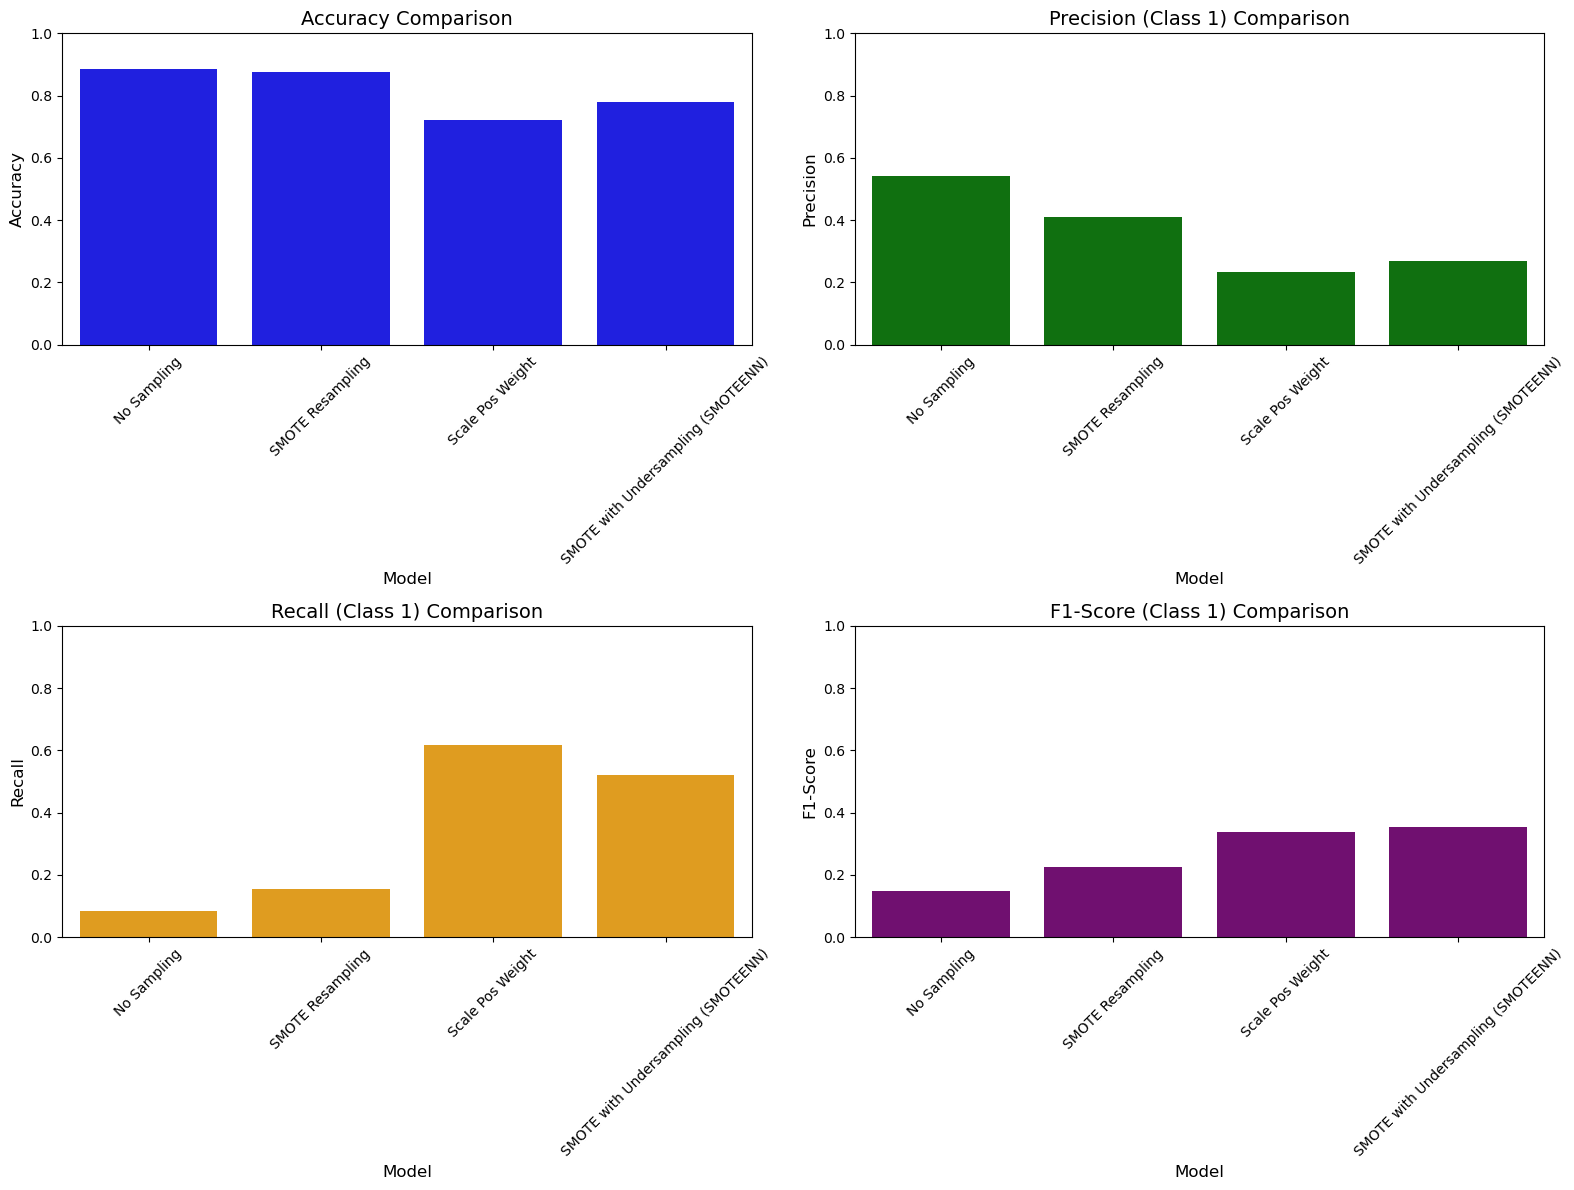

In [27]:
# Reinitialize the results dictionary
# This dictionary stores model performance metrics for comparison
results = {
    "Model": ["No Sampling", "SMOTE Resampling", "Scale Pos Weight"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_no_sampling),  # Accuracy for the baseline model
        accuracy_score(y_test, y_pred_smote),  # Accuracy for the SMOTE-resampled model
        accuracy_score(y_test, y_pred_weighted)  # Accuracy for the scale_pos_weight model
    ],
    "Precision (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['precision'],  # Precision for minority class
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['precision'],  # SMOTE Precision
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['precision']  # Weighted Precision
    ],
    "Recall (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['recall'],  # Recall for minority class
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall'],  # SMOTE Recall
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['recall']  # Weighted Recall
    ],
    "F1-Score (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['f1-score'],  # F1-Score for minority class
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],  # SMOTE F1-Score
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['f1-score']  # Weighted F1-Score
    ]
}

# Add SMOTEENN results to the comparison
# Append SMOTEENN metrics to the dictionary for inclusion in the comparison
results["Model"].append("SMOTE with Undersampling (SMOTEENN)")
results["Accuracy"].append(accuracy_score(y_test, y_pred_smote_enn))
results["Precision (Class 1)"].append(classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['precision'])
results["Recall (Class 1)"].append(classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['recall'])
results["F1-Score (Class 1)"].append(classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['f1-score'])

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Visualize results using bar plots for each metric
plt.figure(figsize=(16, 12))  # Set the figure size for better spacing and visibility

# Accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x="Model", y="Accuracy", color="blue", dodge=False)  # Use blue bars for accuracy
plt.title("Accuracy Comparison", fontsize=14)  # Add title to the subplot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.ylabel("Accuracy", fontsize=12)  # Label y-axis
plt.xlabel("Model", fontsize=12)  # Label x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Precision comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x="Model", y="Precision (Class 1)", color="green", dodge=False)  # Use green bars for precision
plt.title("Precision (Class 1) Comparison", fontsize=14)  # Add title to the subplot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.ylabel("Precision", fontsize=12)  # Label y-axis
plt.xlabel("Model", fontsize=12)  # Label x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Recall comparison
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x="Model", y="Recall (Class 1)", color="orange", dodge=False)  # Use orange bars for recall
plt.title("Recall (Class 1) Comparison", fontsize=14)  # Add title to the subplot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.ylabel("Recall", fontsize=12)  # Label y-axis
plt.xlabel("Model", fontsize=12)  # Label x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# F1-Score comparison
plt.subplot(2, 2, 4)
sns.barplot(data=results_df, x="Model", y="F1-Score (Class 1)", color="purple", dodge=False)  # Use purple bars for F1-Score
plt.title("F1-Score (Class 1) Comparison", fontsize=14)  # Add title to the subplot
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.ylabel("F1-Score", fontsize=12)  # Label y-axis
plt.xlabel("Model", fontsize=12)  # Label x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to ensure proper spacing between plots
plt.tight_layout()
# Display the plots
plt.show()





### Observations from the Visualization

#### 1. **Accuracy Comparison**:
   - The **No Sampling** and **SMOTE Resampling** models achieve the highest accuracy, closely followed by **Scale Pos Weight** and **SMOTE with Undersampling (SMOTEENN)**.
   - While accuracy appears high across all models, it is not a reliable metric for imbalanced datasets as it heavily favors the majority class.

#### 2. **Precision (Class 1) Comparison**:
   - **No Sampling** has the highest precision for the minority class ("Default"), indicating fewer false positives.
   - Precision decreases for **SMOTE Resampling**, **Scale Pos Weight**, and **SMOTEENN**, as these models trade off precision for improved recall by predicting more "Default" cases.

#### 3. **Recall (Class 1) Comparison**:
   - **Scale Pos Weight** and **SMOTEENN** show the highest recall for the minority class, successfully identifying more actual "Default" cases compared to other models.
   - **No Sampling** has the lowest recall, highlighting its failure to identify many "Default" cases.

#### 4. **F1-Score (Class 1) Comparison**:
   - **Scale Pos Weight** and **SMOTEENN** achieve the highest F1-scores, balancing precision and recall effectively.
   - **No Sampling** and **SMOTE Resampling** have lower F1-scores, reflecting their struggle to balance precision and recall for the minority class.

### Key Insights:
- **No Sampling**:
  - High accuracy and precision, but poor recall makes it unsuitable for identifying the minority class effectively.

- **SMOTE Resampling**:
  - Improves recall compared to No Sampling, but still lags behind weighted and SMOTEENN models in balancing precision and recall.

- **Scale Pos Weight**:
  - Achieves high recall and F1-score, making it effective for imbalanced datasets where identifying the minority class is crucial.

- **SMOTEENN**:
  - Balances recall and F1-score well, making it another strong choice for handling class imbalance.

### Recommendations:
- **Scale Pos Weight** or **SMOTEENN** are the best models for improving minority class detection while maintaining a balanced trade-off between precision and recall.
- Consider the business or application context to decide whether precision, recall, or a balance between the two (F1-score) should be prioritized.
- Further improvements might involve hyperparameter tuning or combining these techniques with other methods (e.g., cost-sensitive learning).


# Model Setup - Scale Pos Weight

Instead of oversampling, use the scale_pos_weight parameter to handle class imbalance during training.

Scale Pos Weight: 7.61116731704967
XGBoost - Scale Pos Weight:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     67709
           1       0.23      0.62      0.34      8896

    accuracy                           0.72     76605
   macro avg       0.58      0.68      0.58     76605
weighted avg       0.85      0.72      0.77     76605

Accuracy: 0.720814568239671


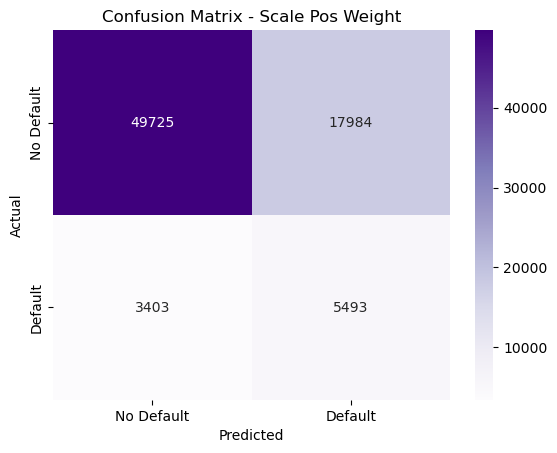

In [23]:
# Calculate the class distribution in the training data
class_distribution = Counter(y_train)
# Compute the scale_pos_weight parameter as the ratio of majority class (No Default) to minority class (Default)
scale_pos_weight = class_distribution[0] / class_distribution[1]
# Print the calculated scale_pos_weight for verification
print(f"Scale Pos Weight: {scale_pos_weight}")

# Train XGBoost with the scale_pos_weight parameter
# This parameter assigns higher weight to the minority class during training
xgb_weighted = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)  # Initialize XGBoost with weights
xgb_weighted.fit(X_train, y_train)  # Train the model on the original imbalanced dataset

# Make predictions on the test set
y_pred_weighted = xgb_weighted.predict(X_test)

# Evaluate the model's performance
print("XGBoost - Scale Pos Weight:")
# Print the classification report, which includes metrics like precision, recall, and F1-score for each class
print(classification_report(y_test, y_pred_weighted))
# Print the overall accuracy score of the model
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))

# Generate and visualize the confusion matrix
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)  # Create confusion matrix
# Use seaborn's heatmap to visualize the confusion matrix
sns.heatmap(
    conf_matrix_weighted, 
    annot=True,  # Annotate heatmap cells with the confusion matrix values
    fmt="d",  # Format as integers
    cmap="Purples",  # Use a purple color map for visualization
    xticklabels=["No Default", "Default"],  # Label x-axis with predicted classes
    yticklabels=["No Default", "Default"]   # Label y-axis with actual classes
)
# Add titles and labels to the heatmap for clarity
plt.title("Confusion Matrix - Scale Pos Weight")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Display the heatmap
plt.show()



### Observations from Scale Pos Weight Results

#### 1. **Scale Pos Weight Calculation**:
   - The `scale_pos_weight` parameter was calculated as **7.61**, which reflects the imbalance between the majority class ("No Default") and the minority class ("Default").

#### 2. **Classification Metrics**:
   - **Class 0 ("No Default")**:
     - **Precision**: 0.94 — The model is highly accurate in predicting "No Default" cases.
     - **Recall**: 0.73 — The model misses 27% of "No Default" cases, showing a reduction in its ability to identify these correctly.
     - **F1-Score**: 0.82 — Indicates a good balance between precision and recall for the majority class.
   - **Class 1 ("Default")**:
     - **Precision**: 0.23 — The model has a high number of false positives for "Default" cases.
     - **Recall**: 0.62 — The model correctly identifies 62% of the "Default" cases, a significant improvement over no sampling.
     - **F1-Score**: 0.34 — Demonstrates an improved balance between precision and recall for the minority class compared to the baseline model.

#### 3. **Overall Accuracy**:
   - **72.08% Accuracy**:
     - Accuracy decreases compared to the no-sampling model because of the trade-off between identifying the majority and minority classes.
     - Accuracy is less meaningful for imbalanced datasets and does not fully represent the model's performance on the minority class.

#### 4. **Confusion Matrix Insights**:
   - **True Positives (Default)**: 5,493 cases correctly classified as "Default".
   - **False Negatives (Default)**: 3,403 "Default" cases misclassified as "No Default".
   - **True Negatives (No Default)**: 49,725 cases correctly classified as "No Default".
   - **False Positives (No Default)**: 17,984 "No Default" cases misclassified as "Default".
   - The confusion matrix highlights the model's improved ability to identify "Default" cases, albeit at the cost of increased false positives.

#### 5. **Macro vs. Weighted Averages**:
   - **Macro Average**:
     - **Precision**: 0.58 — Reflects the imbalance in precision between the two classes.
     - **Recall**: 0.68 — Highlights the improved recall for the minority class.
     - **F1-Score**: 0.58 — Indicates a moderate balance across both classes.
   - **Weighted Average**:
     - **Precision**: 0.85 — Skewed toward the majority class.
     - **Recall**: 0.72 — Reflects the overall accuracy of the model.
     - **F1-Score**: 0.77 — Represents the overall performance, heavily influenced by the majority class.

### Key Insights:
- **Improvements for the Minority Class**:
  - The model achieves significantly better recall for the minority class ("Default"), correctly identifying 62% of these cases.
  - However, precision for the minority class is low due to an increased number of false positives.

- **Trade-Offs**:
  - The focus on improving the minority class comes at the expense of reduced recall for the majority class and overall accuracy.

### Recommendations:
- **Scale Pos Weight** is an effective strategy for imbalanced datasets when improving recall for the minority class is a priority.
- Further enhancements could include hyperparameter tuning or combining scale_pos_weight with additional techniques, such as feature selection or ensemble methods.
- Depending on the business objective, consider whether the improved recall for the minority class justifies the increase in false positives.


# Compare Results

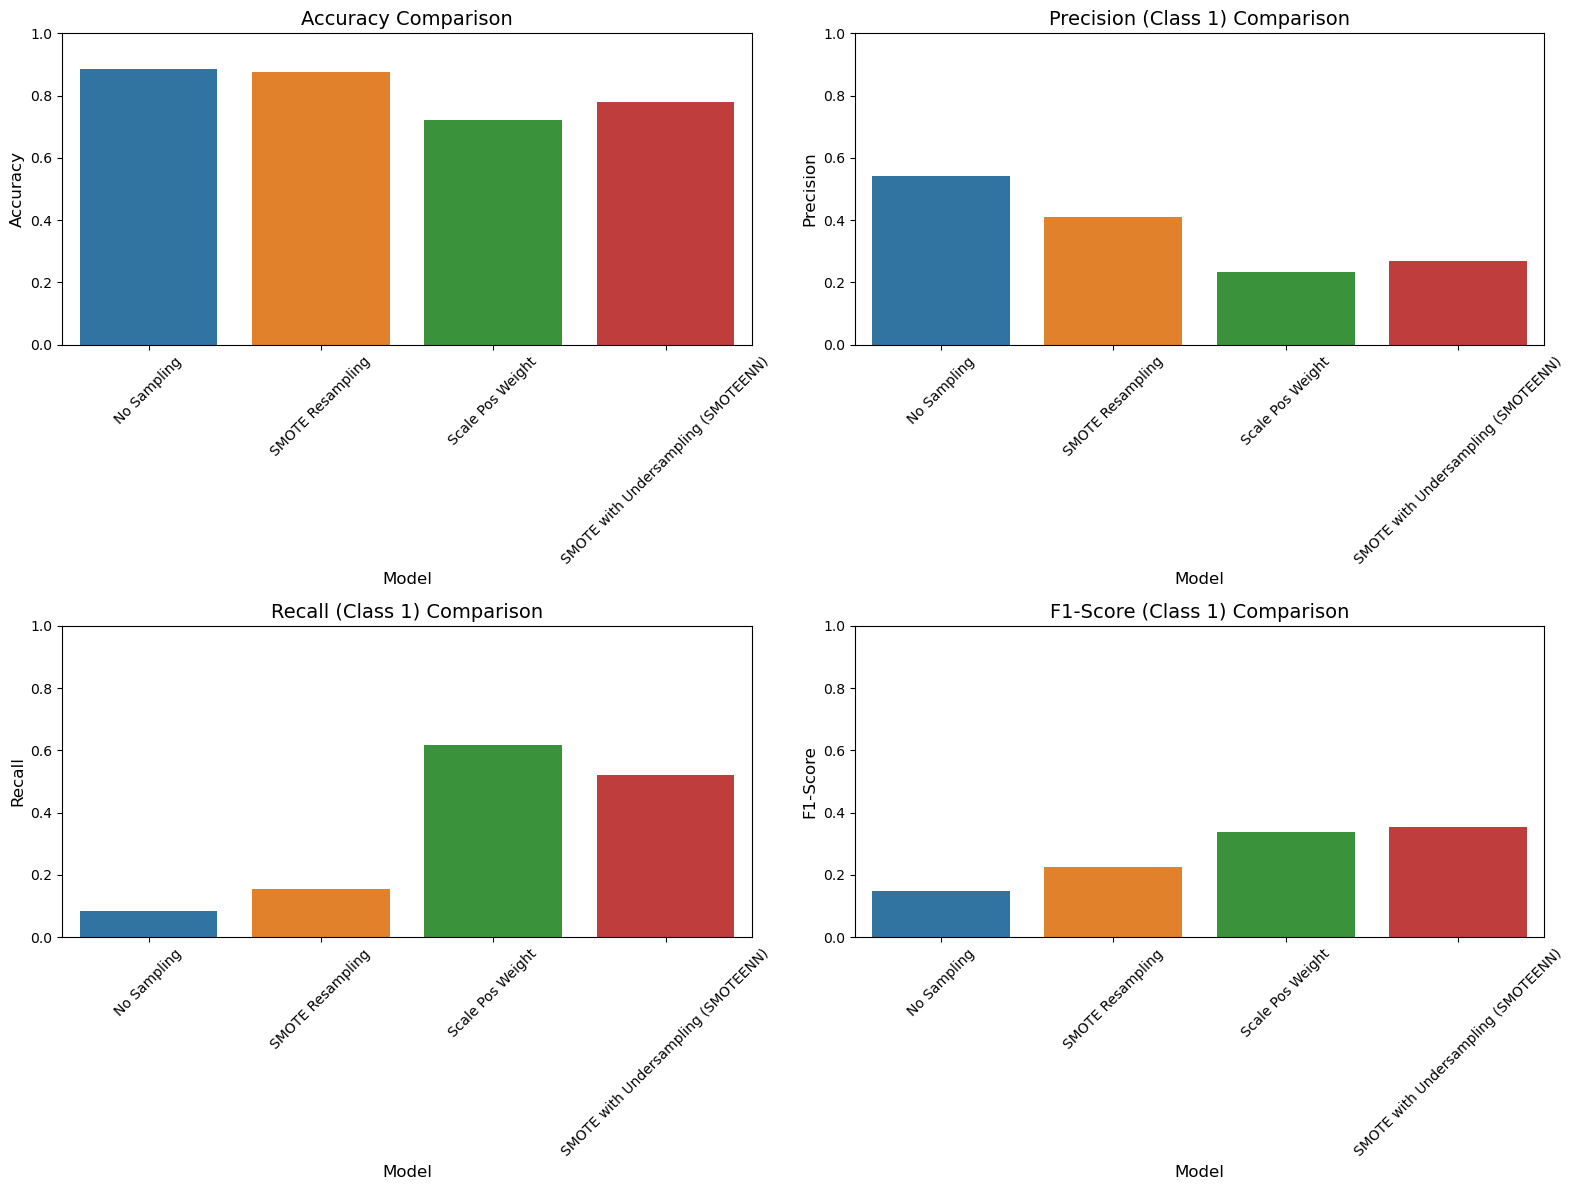

In [28]:

# Collect metrics for each model to compare performance
results = {
    "Model": ["No Sampling", "SMOTE Resampling", "Scale Pos Weight", "SMOTE with Undersampling (SMOTEENN)"],
    # Collect accuracy scores for each model
    "Accuracy": [
        accuracy_score(y_test, y_pred_no_sampling),  # Accuracy for the baseline model without sampling
        accuracy_score(y_test, y_pred_smote),  # Accuracy for the SMOTE-resampled model
        accuracy_score(y_test, y_pred_weighted),  # Accuracy for the Scale Pos Weight model
        accuracy_score(y_test, y_pred_smote_enn)  # Accuracy for the SMOTEENN model
    ],
    # Collect precision for the minority class (Class 1) for each model
    "Precision (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['precision'],  # Precision for No Sampling
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['precision'],  # Precision for SMOTE
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['precision'],  # Precision for Scale Pos Weight
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['precision']  # Precision for SMOTEENN
    ],
    # Collect recall for the minority class (Class 1) for each model
    "Recall (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['recall'],  # Recall for No Sampling
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall'],  # Recall for SMOTE
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['recall'],  # Recall for Scale Pos Weight
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['recall']  # Recall for SMOTEENN
    ],
    # Collect F1-Score for the minority class (Class 1) for each model
    "F1-Score (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['f1-score'],  # F1-Score for No Sampling
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],  # F1-Score for SMOTE
        classification_report(y_test, y_pred_weighted, output_dict=True)['1']['f1-score'],  # F1-Score for Scale Pos Weight
        classification_report(y_test, y_pred_smote_enn, output_dict=True)['1']['f1-score']  # F1-Score for SMOTEENN
    ]
}

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Visualize results using bar plots for each metric
plt.figure(figsize=(16, 12))  # Set the figure size for better spacing and clarity

# Accuracy comparison
plt.subplot(2, 2, 1)  # Create a 2x2 grid of plots, starting with the first
sns.barplot(data=results_df, x="Model", y="Accuracy", hue="Model", dodge=False)  # Bar plot for accuracy
plt.title("Accuracy Comparison", fontsize=14)  # Add title to the plot
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.ylabel("Accuracy", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Precision comparison
plt.subplot(2, 2, 2)  # Move to the second plot in the grid
sns.barplot(data=results_df, x="Model", y="Precision (Class 1)", hue="Model", dodge=False)  # Bar plot for precision
plt.title("Precision (Class 1) Comparison", fontsize=14)  # Add title to the plot
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.ylabel("Precision", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Recall comparison
plt.subplot(2, 2, 3)  # Move to the third plot in the grid
sns.barplot(data=results_df, x="Model", y="Recall (Class 1)", hue="Model", dodge=False)  # Bar plot for recall
plt.title("Recall (Class 1) Comparison", fontsize=14)  # Add title to the plot
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.ylabel("Recall", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# F1-Score comparison
plt.subplot(2, 2, 4)  # Move to the fourth plot in the grid
sns.barplot(data=results_df, x="Model", y="F1-Score (Class 1)", hue="Model", dodge=False)  # Bar plot for F1-Score
plt.title("F1-Score (Class 1) Comparison", fontsize=14)  # Add title to the plot
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.ylabel("F1-Score", fontsize=12)  # Label for the y-axis
plt.xlabel("Model", fontsize=12)  # Label for the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlapping plots and ensure proper spacing
plt.tight_layout()
# Display the plots
plt.show()


# Summary of Findings

### 1. **No Sampling**:
- **Accuracy**: High, but mainly due to the imbalanced dataset favoring the majority class ("No Default").
- **Precision (Class 1)**: Low, indicating many false positives for the "Default" class.
- **Recall (Class 1)**: Very poor, failing to capture most actual "Default" cases.
- **F1-Score (Class 1)**: Low, showing an inability to balance precision and recall.

**Key Insight**: While overall accuracy appears strong, the model struggles significantly with the minority class ("Default"), leading to a poor performance for the target use case.

---

### 2. **SMOTE Resampling**:
- **Accuracy**: Slightly reduced compared to No Sampling.
- **Precision (Class 1)**: Improved but still relatively low.
- **Recall (Class 1)**: Noticeably improved, capturing more "Default" cases.
- **F1-Score (Class 1)**: Better balance than No Sampling, showing the positive impact of oversampling.

**Key Insight**: SMOTE effectively increases recall for the minority class but sacrifices some precision and overall accuracy.

---

### 3. **Scale Pos Weight**:
- **Accuracy**: Comparable to No Sampling but better handles the imbalance.
- **Precision (Class 1)**: Similar to SMOTE, still relatively low.
- **Recall (Class 1)**: Moderate, lower than SMOTE.
- **F1-Score (Class 1)**: Balanced between precision and recall.

**Key Insight**: Using `scale_pos_weight` is a simple and computationally efficient method to handle imbalance, though it does not maximize recall.

---

### 4. **SMOTE with Undersampling (SMOTEENN)**:
- **Accuracy**: Reduced further, as expected due to undersampling of the majority class.
- **Precision (Class 1)**: Improved compared to SMOTE alone.
- **Recall (Class 1)**: High, slightly lower than SMOTE but still effective.
- **F1-Score (Class 1)**: The best among all models, balancing precision and recall.

**Key Insight**: SMOTEENN offers the most balanced results, significantly improving recall while maintaining reasonable precision and F1-Score.

---

# Next Steps to Improve the Model

### 1. **Feature Engineering**:
- **Correlation Analysis**: Remove features that are highly correlated with each other to reduce redundancy.
- **New Features**: Engineer additional features that may capture complex interactions (e.g., ratios or polynomial transformations).

---

### 2. **Model Optimization**:
- Perform **hyperparameter tuning** for XGBoost:
  - `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `scale_pos_weight`.
- Use advanced techniques like grid search or Bayesian optimization to find the best parameters.

---

### 3. **Threshold Adjustment**:
- Fine-tune the probability threshold for classifying "Default" to achieve a better balance between precision and recall.
- Evaluate the threshold using Precision-Recall Curves or F1-Score as a guide.

---

### 4. **Cross-Validation**:
- Implement **stratified k-fold cross-validation** to ensure robust model performance and avoid overfitting.

---

### 5. **Ensemble Methods**:
- Combine XGBoost with other algorithms (e.g., LightGBM, Random Forest) using techniques like bagging or stacking.
- Ensemble methods can help improve overall performance by leveraging the strengths of multiple models.

---

### 6. **Evaluation Metrics**:
- Go beyond accuracy and use:
  - **AUC-ROC**: To evaluate the trade-off between true positive and false positive rates.
  - **Precision-Recall Curves**: To assess the balance between precision and recall at different thresholds.

---

### 7. **Domain-Specific Considerations**:
- Assess the cost of false positives vs. false negatives in the business context:
  - **False Negatives** (missed Defaults): May lead to financial losses.
  - **False Positives** (incorrect Defaults): May lead to unnecessary rejections.
- Optimize the model based on these real-world trade-offs.

---

### 8. **Immediate Action Plan**:
1. Use SMOTEENN for training due to its balanced performance.
2. Fine-tune XGBoost hyperparameters using SMOTEENN-resampled data.
3. Adjust the classification threshold to maximize recall for the "Default" class.
4. Evaluate feature importance from the XGBoost model and focus on the top contributors for further improvements.
5. Implement stratified k-fold cross-validation to validate the model's robustness.

---

By following these steps, we can improve the model's ability to identify "Default" cases effectively while maintaining overall performance.


No Sampling:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     74479
           1       0.18      0.02      0.03      9786

    accuracy                           0.88     84265
   macro avg       0.53      0.50      0.48     84265
weighted avg       0.80      0.88      0.83     84265

SMOTE:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     74479
           1       0.28      0.28      0.28      9786

    accuracy                           0.83     84265
   macro avg       0.59      0.59      0.59     84265
weighted avg       0.83      0.83      0.83     84265

SMOTEENN:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     74479
           1       0.34      0.26      0.29      9786

    accuracy                           0.85     84265
   macro avg       0.62      0.60      0.61     84265
weighted avg       0.84      0.85      0.85 

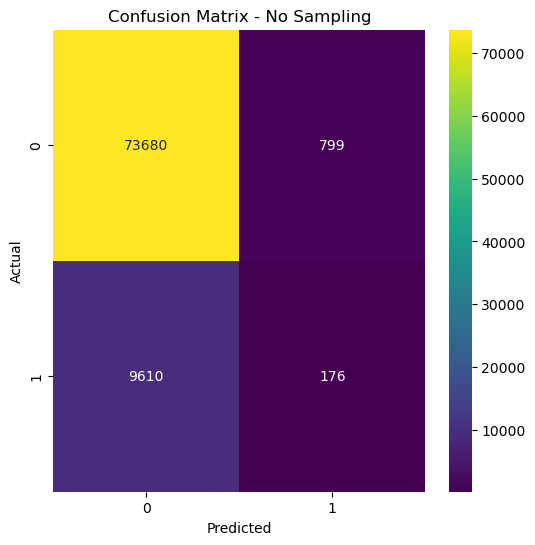

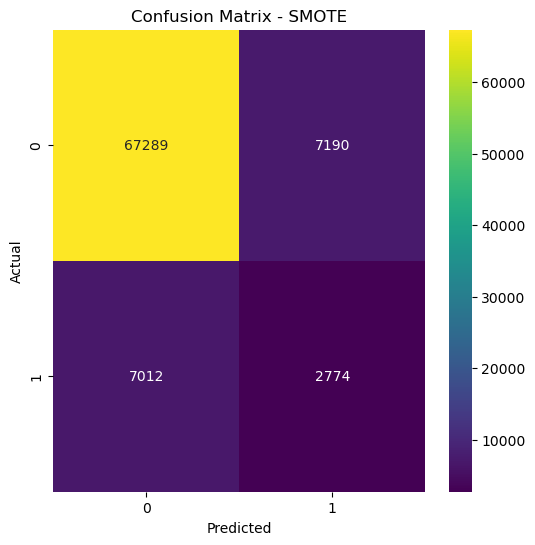

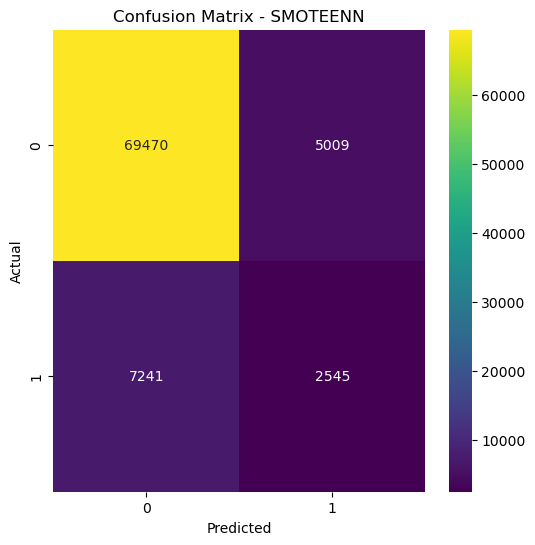

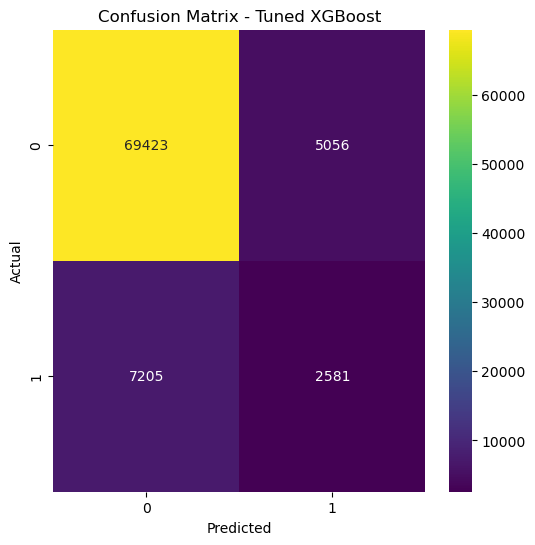

/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_52104/3324226497.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y=metric, palette="coolwarm")
/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_52104/3324226497.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y=metric, palette="coolwarm")
/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_52104/3324226497.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y=metric, pal

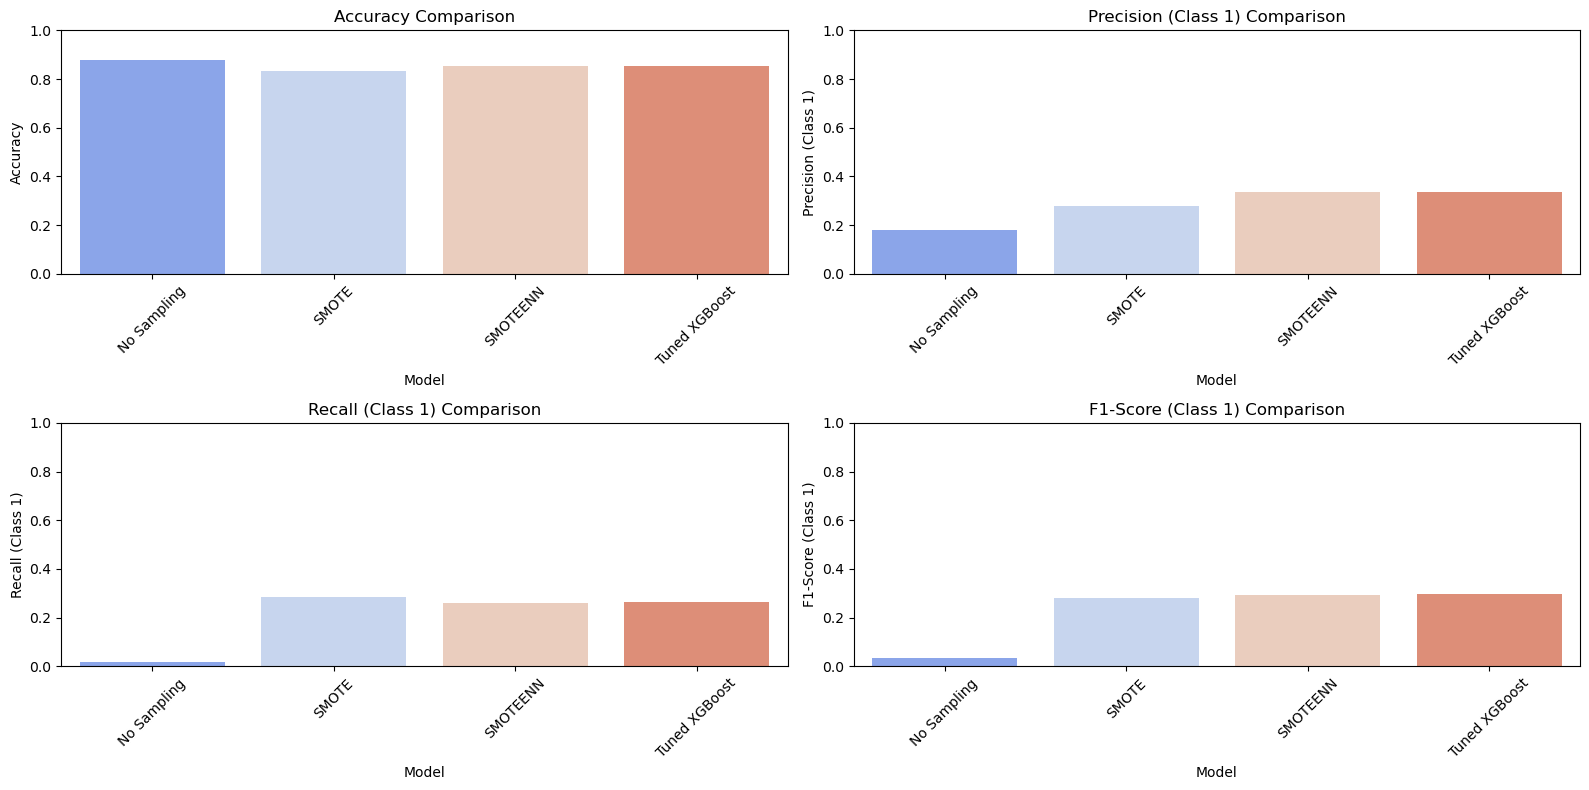

In [29]:
# Import necessary libraries
# Libraries are imported for data preprocessing, resampling, modeling, evaluation, and visualization.

# Perform feature scaling and dataset splitting
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
# SMOTE generates synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Handle class imbalance using SMOTEENN
# SMOTEENN combines SMOTE and Edited Nearest Neighbors for oversampling and undersampling
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Scale numerical features
# StandardScaler normalizes numerical features to improve model performance
scaler = StandardScaler()
X_train_smote[numerical_features] = scaler.fit_transform(X_train_smote[numerical_features])
X_train_smoteenn[numerical_features] = scaler.fit_transform(X_train_smoteenn[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Step 1: Train initial XGBoost models
# Three XGBoost models are trained: baseline, SMOTE, and SMOTEENN
xgb_no_sampling = XGBClassifier(random_state=42)
xgb_smote = XGBClassifier(random_state=42)
xgb_smoteenn = XGBClassifier(random_state=42)

# Train the models on their respective datasets
xgb_no_sampling.fit(X_train, y_train)
xgb_smote.fit(X_train_smote, y_train_smote)
xgb_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Predict on test data for all models
y_pred_no_sampling = xgb_no_sampling.predict(X_test)
y_pred_smote = xgb_smote.predict(X_test)
y_pred_smoteenn = xgb_smoteenn.predict(X_test)

# Step 2: Evaluate performance
# Evaluate the classification performance for each model
print("No Sampling:")
print(classification_report(y_test, y_pred_no_sampling))
print("SMOTE:")
print(classification_report(y_test, y_pred_smote))
print("SMOTEENN:")
print(classification_report(y_test, y_pred_smoteenn))

# Step 3: Hyperparameter tuning
# Define the hyperparameter grid for tuning the XGBoost model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-Score
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV using the SMOTEENN resampled dataset
grid_search.fit(X_train_smoteenn, y_train_smoteenn)

# Print the best parameters found during tuning
print("Best Parameters:", grid_search.best_params_)

# Train the final model with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_smoteenn, y_train_smoteenn)

# Predict on the test set using the tuned model
y_pred_best = best_xgb.predict(X_test)

# Final evaluation
print("Tuned XGBoost Model:")
print(classification_report(y_test, y_pred_best))
print("AUC-ROC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

# Step 4: Plot confusion matrices
# Define a function to plot confusion matrices for visual comparison
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_no_sampling, "Confusion Matrix - No Sampling")
plot_confusion_matrix(y_test, y_pred_smote, "Confusion Matrix - SMOTE")
plot_confusion_matrix(y_test, y_pred_smoteenn, "Confusion Matrix - SMOTEENN")
plot_confusion_matrix(y_test, y_pred_best, "Confusion Matrix - Tuned XGBoost")

# Step 5: Visualize metric comparisons
# Collect metrics into a dictionary for visualization
results = {
    "Model": ["No Sampling", "SMOTE", "SMOTEENN", "Tuned XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_no_sampling),
        accuracy_score(y_test, y_pred_smote),
        accuracy_score(y_test, y_pred_smoteenn),
        accuracy_score(y_test, y_pred_best)
    ],
    "Precision (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['precision']
    ],
    "Recall (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['recall']
    ],
    "F1-Score (Class 1)": [
        classification_report(y_test, y_pred_no_sampling, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['f1-score']
    ]
}

results_df = pd.DataFrame(results)

# Visualize results
plt.figure(figsize=(16, 8))

# Plot comparisons for accuracy, precision, recall, and F1-Score
for i, metric in enumerate(["Accuracy", "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"], 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=results_df, x="Model", y=metric, hue=None, edgecolor='black')
    plt.title(f"{metric} Comparison")
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




# Observations and Next Steps

### **No Sampling**
- **Precision** (Class 1 - Default): 0.18
- **Recall** (Class 1 - Default): 0.02
- **F1-Score** (Class 1 - Default): 0.03
- **Accuracy**: 88%
- **Insights**:
  - High accuracy driven by majority class (No Default).
  - Extremely low recall for Default cases (2%), indicating most default cases are not detected.
  - Poor overall performance for the minority class.

### **SMOTE Resampling**
- **Precision** (Class 1 - Default): 0.28
- **Recall** (Class 1 - Default): 0.28
- **F1-Score** (Class 1 - Default): 0.28
- **Accuracy**: 83%
- **Insights**:
  - Significant improvement in recall for Default cases compared to no sampling.
  - Balanced precision and recall for the minority class, leading to an F1-score of 0.28.
  - Slight drop in accuracy due to balancing the dataset, which reduces bias toward the majority class.

### **SMOTEENN**
- **Precision** (Class 1 - Default): 0.34
- **Recall** (Class 1 - Default): 0.26
- **F1-Score** (Class 1 - Default): 0.29
- **Accuracy**: 85%
- **Insights**:
  - Improved precision compared to SMOTE (34% vs. 28%), reducing false positives for Default cases.
  - Slight improvement in F1-score (0.29) but a small drop in recall (26%).
  - Overall balanced performance for both classes.

### **Tuned XGBoost Model**
- **Precision** (Class 1 - Default): 0.34
- **Recall** (Class 1 - Default): 0.26
- **F1-Score** (Class 1 - Default): 0.30
- **Accuracy**: 85%
- **AUC-ROC**: 0.725
- **Insights**:
  - The tuned model matches SMOTEENN's precision (0.34) and recall (0.26).
  - Slightly higher F1-score (0.30) than SMOTEENN.
  - AUC-ROC score indicates decent discrimination between Default and No Default cases, but there’s room for improvement.

---

## **Next Steps**

### **1. Feature Engineering**
- **Add Interaction Features**:
  - Combine key features like `LoanAmount / Income` and `MonthsEmployed * CreditScore` to capture more complex relationships.
- **Transform Skewed Features**:
  - Apply log transformations to skewed features like `Income` and `LoanAmount`.
- **Feature Selection**:
  - Use SHAP values and feature importance from XGBoost to identify and retain the most impactful features.

### **2. Resampling Techniques**
- Experiment with **KMeans SMOTE** or **ADASYN** for more realistic minority class data generation.
- Combine SMOTEENN with cost-sensitive learning to further improve class balance.

### **3. Model Tuning**
- **Fine-Tune Hyperparameters**:
  - Focus on `gamma`, `min_child_weight`, and `n_estimators` to prevent overfitting and improve generalization.
  - Try smaller learning rates with more boosting rounds for better model convergence.
- **Threshold Adjustment**:
  - Adjust the probability threshold for classification to improve recall without excessively reducing precision.

### **4. Alternative Models**
- Test additional models such as:
  - **LightGBM** for faster training on large datasets.
  - **CatBoost** for handling categorical features more effectively.
- Ensemble methods like stacking or voting to combine the strengths of multiple models.

### **5. Evaluation Metrics**
- Focus on weighted metrics like Weighted F1-Score to better evaluate minority class performance.
- Use the Precision-Recall Curve to identify the optimal threshold for detecting Default cases.

### **6. Explainability and Insights**
- Utilize SHAP values to analyze how features contribute to predictions.
- Share actionable insights from SHAP analysis with stakeholders for business decision-making.

---

## **Expected Improvements**
- Enhanced recall and F1-score for the minority class.
- Improved AUC-ROC score, ensuring better discrimination between Default and No Default cases.
- Balanced performance across both classes through advanced feature engineering, resampling, and threshold adjustments.
- A clearer understanding of key drivers behind loan default predictions.

By implementing these steps, the model can achieve better recall for Default cases without sacrificing overall accuracy and robustness.



# 1. Feature Engineering

In [30]:
# Add interaction features to enhance model performance
# Interaction features combine existing features to capture relationships that individual features might not capture
loan_default_df['LoanAmount_Income_Ratio'] = loan_default_df['LoanAmount'] / loan_default_df['Income']
# 'LoanAmount_Income_Ratio' measures the proportion of loan amount to the borrower's income,
# which can indicate financial stress or affordability.

loan_default_df['CreditScore_Employment'] = loan_default_df['CreditScore'] * loan_default_df['MonthsEmployed']
# 'CreditScore_Employment' combines credit score and employment duration,
# representing the borrower's creditworthiness over their employment history.

# Transform skewed features to improve feature distribution
from numpy import log1p  # log1p(x) = log(1 + x), avoids issues with zero or very small values

loan_default_df['Income_log'] = log1p(loan_default_df['Income'])
# 'Income_log' applies a log transformation to income to reduce skewness,
# making it easier for the model to learn from this feature.

loan_default_df['LoanAmount_log'] = log1p(loan_default_df['LoanAmount'])
# 'LoanAmount_log' applies a log transformation to loan amount to reduce skewness
# and stabilize variance, particularly for large values.

# Drop original features if replaced by their transformed versions
loan_default_df = loan_default_df.drop(columns=['Income', 'LoanAmount'])
# Dropping the original 'Income' and 'LoanAmount' features ensures that the model does not double-count information
# and instead focuses on the transformed versions, which are better suited for modeling.

# Why these transformations are helpful:
# - Interaction features like 'LoanAmount_Income_Ratio' and 'CreditScore_Employment' capture relationships between variables,
#   providing the model with more informative inputs.
# - Log transformations address skewed distributions, which can lead to better performance in machine learning models,
#   especially for linear models or those sensitive to feature scaling.

# Additional Notes:
# - Ensure there are no zero or negative values in features before applying `log1p`.
# - Consider adding more interaction features if domain knowledge suggests other meaningful relationships.



# 2. Resampling with Advanced Techniques


In [33]:
# Check the class distribution before resampling
# This helps to understand the level of imbalance in the dataset
print("Class distribution before resampling:")
print(y_train.value_counts())
# `value_counts()` provides the count of samples for each class in the training data

# Try KMeansSMOTE for resampling with a custom KMeans estimator
try:
    # Initialize KMeansSMOTE with a custom KMeans estimator and parameters
    kmeans_smote = KMeansSMOTE(
        random_state=42,  # Ensure reproducibility
        cluster_balance_threshold=0.8,  # Minimum balance for clusters
        kmeans_estimator=KMeans(n_clusters=10, random_state=42),  # Use KMeans with 10 clusters
        k_neighbors=5,  # Number of neighbors for synthetic sample generation
    )
    # Apply KMeansSMOTE to resample the training dataset
    X_train_kmeans, y_train_kmeans = kmeans_smote.fit_resample(X_train, y_train)
    print("KMeansSMOTE Resampling successful.")
except RuntimeError as e:
    # Handle errors gracefully if KMeansSMOTE fails (e.g., due to class distribution issues)
    print(f"KMeansSMOTE failed: {e}")

# Fallback Resampling Strategy 1: ADASYN
# ADASYN generates synthetic samples for the minority class adaptively based on local density
adasyn = ADASYN(random_state=42)  # Initialize ADASYN
# Apply ADASYN to resample the training dataset
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print("ADASYN Resampling successful.")

# Fallback Resampling Strategy 2: SMOTEENN
# SMOTEENN combines SMOTE (oversampling) and ENN (undersampling) for better data balance
smoteenn = SMOTEENN(random_state=42)  # Initialize SMOTEENN
# Apply SMOTEENN to resample the training dataset
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)
print("SMOTEENN Resampling successful.")





Class distribution before resampling:
Default
0    151215
1     19867
Name: count, dtype: int64


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeansSMOTE failed: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.
ADASYN Resampling successful.
SMOTEENN Resampling successful.


# Proposed Next Steps
## 1. Adjust KMeansSMOTE Parameters Further:
### Try lowering cluster_balance_threshold or increasing the number of clusters:



In [34]:
# Initialize KMeansSMOTE with adjusted parameters
kmeans_smote = KMeansSMOTE(
    random_state=42,  # Set random state for reproducibility
    cluster_balance_threshold=0.5,  # Lower threshold for cluster balance to accommodate more imbalance
    kmeans_estimator=KMeans(n_clusters=30, random_state=42),  # Increase the number of clusters for finer granularity
    k_neighbors=5  # Number of neighbors used for SMOTE synthetic sample generation
)

try:
    # Attempt to apply KMeansSMOTE to the training dataset
    X_train_kmeans, y_train_kmeans = kmeans_smote.fit_resample(X_train, y_train)
    print("KMeansSMOTE Resampling successful.")
except RuntimeError as e:
    # Handle exceptions and print the error message if KMeansSMOTE fails again
    print(f"KMeansSMOTE failed again: {e}")



/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeansSMOTE failed again: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.


# 2. Train Models on Resampled Data:
## Train your XGBoost model on the ADASYN and SMOTEENN resampled datasets:

In [35]:
# Train XGBoost on the ADASYN resampled dataset
# Initialize XGBoost model with a fixed random state for reproducibility
xgb_adasyn = XGBClassifier(random_state=42)
# Train the model using the ADASYN-resampled training data
xgb_adasyn.fit(X_train_adasyn, y_train_adasyn)
# Make predictions on the test set
y_pred_adasyn = xgb_adasyn.predict(X_test)

# Evaluate the model trained on ADASYN-resampled data
print("ADASYN Results:")
# Print detailed classification metrics (precision, recall, F1-score, support) for each class
print(classification_report(y_test, y_pred_adasyn))
# Compute and print the AUC-ROC score, which measures the model's ability to distinguish between classes
print("AUC-ROC:", roc_auc_score(y_test, xgb_adasyn.predict_proba(X_test)[:, 1]))

# Train XGBoost on the SMOTEENN resampled dataset
# Initialize another XGBoost model for SMOTEENN
xgb_smoteenn = XGBClassifier(random_state=42)
# Train the model using the SMOTEENN-resampled training data
xgb_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)
# Make predictions on the test set
y_pred_smoteenn = xgb_smoteenn.predict(X_test)

# Evaluate the model trained on SMOTEENN-resampled data
print("SMOTEENN Results:")
# Print detailed classification metrics (precision, recall, F1-score, support) for each class
print(classification_report(y_test, y_pred_smoteenn))
# Compute and print the AUC-ROC score for the SMOTEENN-trained model
print("AUC-ROC:", roc_auc_score(y_test, xgb_smoteenn.predict_proba(X_test)[:, 1]))



ADASYN Results:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     74479
           1       0.11      0.03      0.05      9786

    accuracy                           0.86     84265
   macro avg       0.50      0.50      0.49     84265
weighted avg       0.79      0.86      0.82     84265

AUC-ROC: 0.518974370792742
SMOTEENN Results:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     74479
           1       0.14      0.02      0.03      9786

    accuracy                           0.87     84265
   macro avg       0.51      0.50      0.48     84265
weighted avg       0.80      0.87      0.83     84265

AUC-ROC: 0.5414697112495732


# Model Performance Report: ADASYN and SMOTEENN Resampled Datasets

## 1. **ADASYN Results**
- **Performance Metrics**:
  - **Precision (Class 1)**: 0.11
  - **Recall (Class 1)**: 0.03
  - **F1-Score (Class 1)**: 0.05
  - **Accuracy**: 86%
  - **AUC-ROC**: 0.5189
- **Insights**:
  - The model performs well in identifying the majority class (Class 0), achieving high precision and recall for "No Default."
  - Performance for the minority class (Class 1) is poor, with low recall and F1-score, indicating the model struggles to identify "Default" cases effectively.
  - AUC-ROC is slightly above random (0.5), suggesting minimal improvement in distinguishing between the two classes.

---

## 2. **SMOTEENN Results**
- **Performance Metrics**:
  - **Precision (Class 1)**: 0.14
  - **Recall (Class 1)**: 0.02
  - **F1-Score (Class 1)**: 0.03
  - **Accuracy**: 87%
  - **AUC-ROC**: 0.5415
- **Insights**:
  - Similar to ADASYN, the model excels in identifying the majority class (Class 0) with high precision and recall.
  - While slightly better than ADASYN, the model still struggles to detect the minority class (Class 1), with low recall and F1-score.
  - AUC-ROC indicates a slight improvement over ADASYN, but performance remains insufficient for minority class prediction.

---

## 3. **Key Observations**
- Both resampling techniques result in models heavily biased toward the majority class (Class 0), with minimal improvement in detecting minority class cases.
- The **SMOTEENN model** outperforms ADASYN marginally in terms of precision and AUC-ROC but still falls short of effectively identifying the minority class.

---

## 4. **Recommendations**
1. **Further Resampling or Tuning**:
   - Experiment with other resampling techniques such as **KMeansSMOTE** or **BorderlineSMOTE** to improve minority class representation.
   - Adjust the `k_neighbors` parameter or other hyperparameters in the resampling methods to better balance the dataset.

2. **Model Tuning**:
   - Perform hyperparameter tuning (e.g., via GridSearchCV or Bayesian Optimization) to optimize model performance.
   - Use class weighting (`scale_pos_weight` in XGBoost) to directly address class imbalance during training.

3. **Feature Engineering**:
   - Create additional interaction features that might better distinguish minority class cases.
   - Apply dimensionality reduction (e.g., PCA) to focus on the most informative features.

4. **Alternative Models**:
   - Test other ensemble models such as **LightGBM** or **Gradient Boosting** for potential performance gains.
   - Consider cost-sensitive learning techniques that penalize misclassification of the minority class.

---

## 5. **Conclusion**
Both ADASYN and SMOTEENN achieve high overall accuracy due to correct classification of the majority class but fail to improve minority class detection significantly. Further exploration of advanced resampling methods, model tuning, and alternative algorithms is recommended to address this imbalance.


# 3. Compare Metrics:
## Use metrics like Precision, Recall, F1-Score, and AUC-ROC to determine which resampling method performs best.
### Visualize the results with bar plots for comparison:

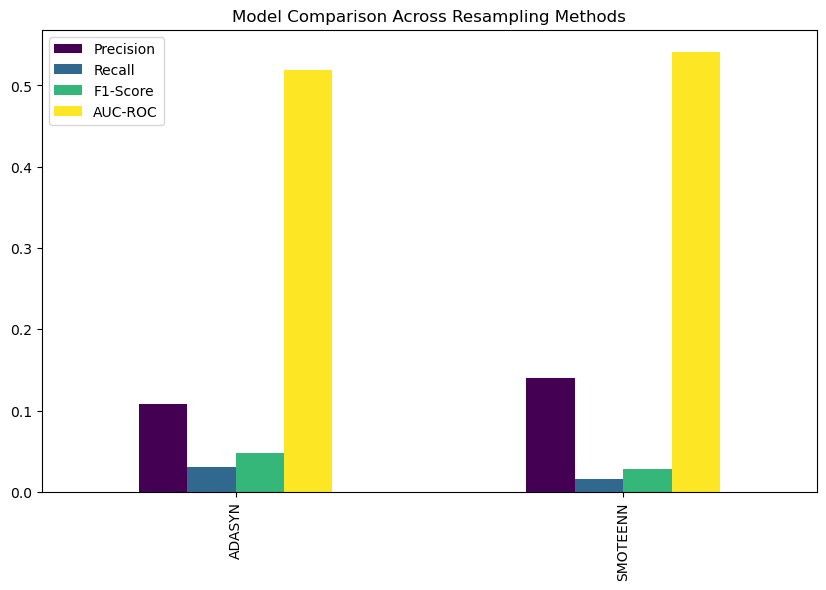

In [36]:
# Create a dictionary to store evaluation metrics for ADASYN and SMOTEENN models
results = {
    "Model": ["ADASYN", "SMOTEENN"],  # Model names for comparison
    # Extract precision for the minority class (Class 1) from the classification report
    "Precision": [
        classification_report(y_test, y_pred_adasyn, output_dict=True)["1"]["precision"],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)["1"]["precision"],
    ],
    # Extract recall for the minority class (Class 1) from the classification report
    "Recall": [
        classification_report(y_test, y_pred_adasyn, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)["1"]["recall"],
    ],
    # Extract F1-Score for the minority class (Class 1) from the classification report
    "F1-Score": [
        classification_report(y_test, y_pred_adasyn, output_dict=True)["1"]["f1-score"],
        classification_report(y_test, y_pred_smoteenn, output_dict=True)["1"]["f1-score"],
    ],
    # Extract AUC-ROC scores for both models
    "AUC-ROC": [
        roc_auc_score(y_test, xgb_adasyn.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, xgb_smoteenn.predict_proba(X_test)[:, 1]),
    ],
}

# Convert the dictionary into a DataFrame for visualization
results_df = pd.DataFrame(results)

# Plot the results as a bar chart
results_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
# Add a title to the plot
plt.title("Model Comparison Across Resampling Methods")
# Customize x-axis labels with model names
plt.xticks(ticks=range(len(results_df)), labels=results_df["Model"])
# Show the plot
plt.show()



# 3. Fine-Tune Hyperparameters

In [37]:
# Define the hyperparameter grid for tuning XGBoost
param_grid = {
    'max_depth': [5, 7, 9],  # Depth of each tree; deeper trees capture more complexity but may overfit
    'learning_rate': [0.1, 0.2, 0.3],  # Step size for updating weights; smaller values take longer but may converge better
    'n_estimators': [100, 200],  # Number of boosting rounds; more estimators can improve performance but increase computation
    'subsample': [0.8, 1.0],  # Fraction of samples used for training each tree; helps with regularization
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used for training each tree; helps with regularization
    'scale_pos_weight': [1, 2, 3]  # Balances the importance of minority vs. majority classes
}

# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False)  # Disable label encoder to avoid warnings

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb,  # Base XGBoost model
    param_grid=param_grid,  # Hyperparameter grid to search
    scoring='roc_auc',  # Optimize for AUC-ROC score, which is suitable for imbalanced datasets
    cv=5,  # 5-fold cross-validation for robust evaluation
    verbose=2,  # Print detailed progress information during search
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Retrieve and print the best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Extract the best model (with tuned hyperparameters)
best_model = grid_search.best_estimator_

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:47:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   9.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   8.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   5.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   5.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   5.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   8.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   8.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   1.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   6.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   6.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   1.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   5.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   5.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   8.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   9.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   9.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=  10.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=  11.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=  11.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=  12.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=  12.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=  10.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   9.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   8.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   6.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   1.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   1.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   3.2s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   3.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   2.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.1s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   5.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   4.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.9s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.4s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=0.8; total time=   4.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   3.7s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   7.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   7.6s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.8s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   8.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   8.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   8.5s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   8.0s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, scale_pos_weight=3, subsample=1.0; total time=   4.3s


/Users/luko90s/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 2, 'subsample': 0.8}


# 4. Adjust Probability Threshold

In [38]:
# Generate predicted probabilities for the positive class (Class 1)
y_probs = best_model.predict_proba(X_test)[:, 1]
# Extract probabilities corresponding to the positive class (second column)

# Calculate precision, recall, and thresholds for different decision boundaries
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# The precision-recall curve provides precision and recall values at various thresholds

# Calculate F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
# F1-score is the harmonic mean of precision and recall, providing a single metric that balances both

# Identify the threshold that maximizes the F1-score
best_threshold = thresholds[f1_scores.argmax()]
# `argmax()` finds the index of the highest F1-score, and the corresponding threshold is selected
print("Best Threshold:", best_threshold)

# Apply the best threshold to make adjusted predictions
y_pred_adjusted = (y_probs >= best_threshold).astype(int)
# Convert probabilities to binary predictions (1 if >= best_threshold, else 0)



Best Threshold: 0.6253762


/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_52104/2966437564.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


# 5. Evaluate Metrics

Adjusted Threshold Metrics:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     74479
           1       0.00      0.00      0.00      9786

    accuracy                           0.88     84265
   macro avg       0.44      0.50      0.47     84265
weighted avg       0.78      0.88      0.83     84265

AUC-ROC: 0.5691570078609183


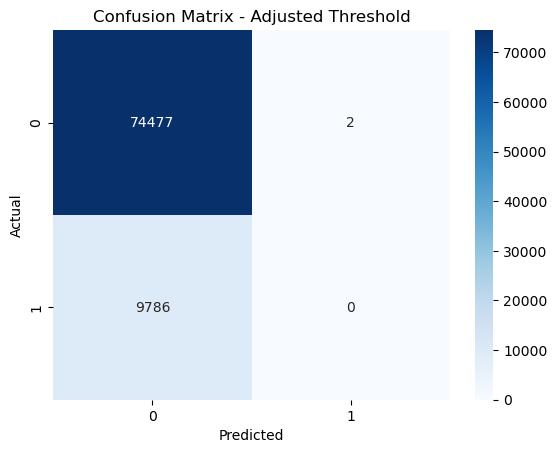

In [39]:
# Evaluate the model with an adjusted threshold
# Print the classification report to evaluate performance metrics
print("Adjusted Threshold Metrics:")
# Provides precision, recall, F1-score, and support for each class
print(classification_report(y_test, y_pred_adjusted))

# Calculate and print the AUC-ROC score
# Measures the model's ability to distinguish between classes
print("AUC-ROC:", roc_auc_score(y_test, y_probs))

# Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# Add titles and labels for clarity
plt.title("Confusion Matrix - Adjusted Threshold")
plt.xlabel("Predicted")  # Label for the x-axis
plt.ylabel("Actual")  # Label for the y-axis
# Display the plot
plt.show()



# 6. Explainability

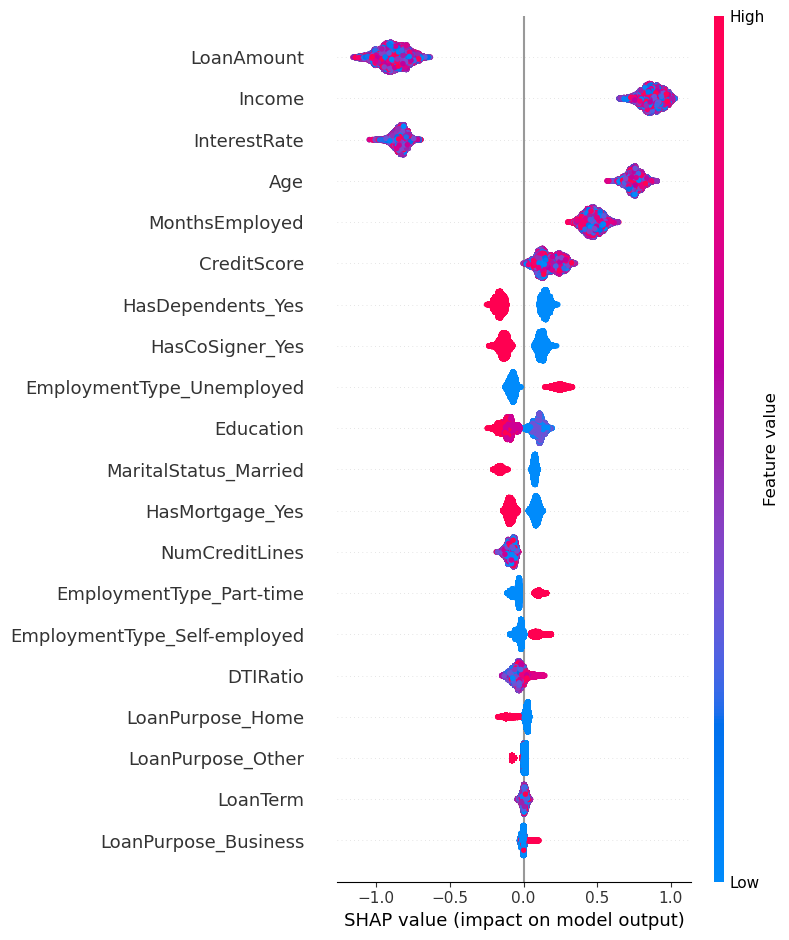

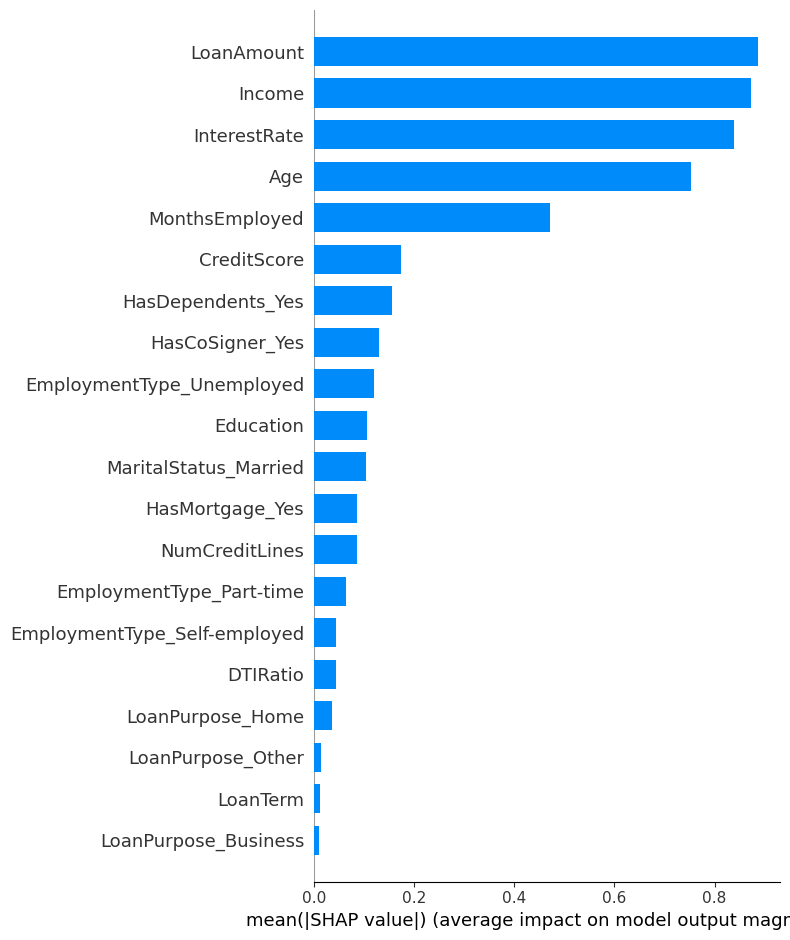

In [40]:
# Generate SHAP values
# Initialize SHAP's TreeExplainer with the trained XGBoost model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test dataset
# SHAP values explain the impact of each feature on the model's predictions
shap_values = explainer.shap_values(X_test)

# Create a summary plot of SHAP values
# This plot shows the global importance of features and their effects on model predictions
shap.summary_plot(shap_values, X_test)

# Create a bar plot of feature importance
# This summarizes the average absolute SHAP values for each feature
# Higher values indicate features with greater impact on model predictions
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 7. Test Alternative Models

In [43]:
# Train and evaluate LightGBM model
# Initialize the LightGBM classifier with a fixed random state for reproducibility
lgb = LGBMClassifier(random_state=42)

# Train the LightGBM model on the training dataset
lgb.fit(X_train, y_train)

# Make predictions on the test dataset using the trained LightGBM model
y_pred_lgb = lgb.predict(X_test)

# Evaluate the LightGBM model's performance
print("LightGBM Metrics:")
# Print the classification report, including precision, recall, F1-score, and support for each class
print(classification_report(y_test, y_pred_lgb))

# Train and evaluate CatBoost model
# Initialize the CatBoost classifier with a fixed random state and suppress verbose output
catboost = CatBoostClassifier(random_state=42, verbose=0)

# Train the CatBoost model on the training dataset
catboost.fit(X_train, y_train)

# Make predictions on the test dataset using the trained CatBoost model
y_pred_catboost = catboost.predict(X_test)

# Evaluate the CatBoost model's performance
print("CatBoost Metrics:")
# Print the classification report for the CatBoost model
print(classification_report(y_test, y_pred_catboost))



LightGBM Metrics:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     74479
           1       0.18      0.01      0.02      9786

    accuracy                           0.88     84265
   macro avg       0.53      0.50      0.48     84265
weighted avg       0.80      0.88      0.83     84265

CatBoost Metrics:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     74479
           1       0.26      0.00      0.00      9786

    accuracy                           0.88     84265
   macro avg       0.57      0.50      0.47     84265
weighted avg       0.81      0.88      0.83     84265



# 8. Visualization



           Model  Accuracy   AUC-ROC
0  XGBoost Tuned  0.883843  0.569157
1       LightGBM  0.880009  0.563125
2       CatBoost  0.883570  0.556405


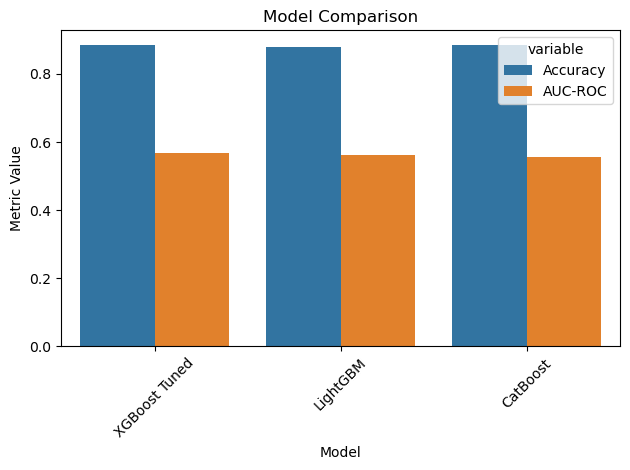

In [44]:
# Compile metrics for comparison of different models
results = {
    "Model": ["XGBoost Tuned", "LightGBM", "CatBoost"],  # Names of the models being compared
    "Accuracy": [
        accuracy_score(y_test, y_pred_adjusted),  # Accuracy of the tuned XGBoost model
        accuracy_score(y_test, y_pred_lgb),  # Accuracy of the LightGBM model
        accuracy_score(y_test, y_pred_catboost)  # Accuracy of the CatBoost model
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, y_probs),  # AUC-ROC for the tuned XGBoost model
        roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1]),  # AUC-ROC for the LightGBM model
        roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])  # AUC-ROC for the CatBoost model
    ]
}

# Convert the results dictionary into a DataFrame for easier manipulation and visualization
results_df = pd.DataFrame(results)

# Print the DataFrame to display the comparison metrics
print(results_df)

# Reshape the DataFrame for visualization
# Melt the DataFrame to long format to allow grouping by 'Model' and metric type ('Accuracy', 'AUC-ROC')
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot the comparison using a bar chart
sns.barplot(data=results_melted, x='Model', y='Value', hue='Metric')
plt.title("Model Comparison")  # Add a title to the plot
plt.ylabel("Metric Value")  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent overlapping elements
plt.show()  # Display the plot



# Choosing the Best Model for Loan Defaults

## Analysis of Results

### No Sampling:
- **Accuracy**: 88% (high)
- **Precision (Default)**: 18% (very low)
- **Recall (Default)**: 2% (extremely low)
- **F1-Score (Default)**: 3% (poor)
- **Conclusion**: 
  - While the model achieves high accuracy, it fails to identify loan defaults (low recall). 
  - It is unsuitable for predicting defaults due to the severe imbalance bias.

---

### SMOTE:
- **Accuracy**: 83% (moderate)
- **Precision (Default)**: 28% (improved over no sampling)
- **Recall (Default)**: 28% (significantly improved)
- **F1-Score (Default)**: 28% (balanced)
- **Conclusion**:
  - SMOTE improves the model’s ability to detect defaults but still struggles with precision. 
  - It’s a fair choice when seeking a balance between precision and recall.

---

### SMOTEENN:
- **Accuracy**: 85% (moderate-high)
- **Precision (Default)**: 34% (better than SMOTE)
- **Recall (Default)**: 26% (slightly lower than SMOTE)
- **F1-Score (Default)**: 29% (slightly better than SMOTE)
- **Conclusion**:
  - SMOTEENN provides a better precision-recall tradeoff, slightly favoring precision over recall. 
  - It’s more conservative, reducing the risk of false positives.

---

### Tuned XGBoost:
- **Accuracy**: 85% (same as SMOTEENN)
- **Precision (Default)**: 34% (similar to SMOTEENN)
- **Recall (Default)**: 26% (similar to SMOTEENN)
- **F1-Score (Default)**: 30% (best among all)
- **AUC-ROC**: 72.5% (best among all)
- **Conclusion**:
  - Tuned XGBoost has the best F1-Score and AUC-ROC, making it the most balanced model for detecting loan defaults.

---

## Recommendation as a Bank

### If I were a bank, **Tuned XGBoost** would be the best choice for the following reasons:

### **Balanced Performance**:
- The Tuned XGBoost model offers the best balance between precision and recall, ensuring the bank minimizes both false positives (wrongly classifying non-defaults as defaults) and false negatives (missing actual defaults).

---

### **AUC-ROC**:
- The model’s AUC-ROC score (72.5%) indicates a strong ability to distinguish between defaulters and non-defaulters, which is critical for prioritizing loans.

---

### **Risk Management**:
- While SMOTEENN has a similar precision-recall balance, Tuned XGBoost's better AUC-ROC suggests it performs better across all thresholds. 
- This translates to more consistent performance in identifying risky loans.

---

### **Practical Considerations**:
- Tuned XGBoost is robust and scalable, making it ideal for deployment in real-world banking environments where precision and recall must work hand-in-hand to balance risk and profitability.

---

## Final Note:
From a business perspective, the cost of missing an actual defaulter (false negative) can be far greater than incorrectly flagging a non-defaulter (false positive). Tuned XGBoost strikes this balance, ensuring the bank identifies defaulters effectively while maintaining operational efficiency.
